In [61]:
import os
import fnmatch
import os.path
import re
import shutil
from pylab import *

import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
from skimage.feature import canny, match_template, peak_local_max
from skimage.transform import resize
from skimage.draw import circle_perimeter, disk, ellipse

from scipy import ndimage, signal, spatial
import scipy.optimize as opt

from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.cluster import KMeans, OPTICS
import sklearn.decomposition as skld
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

plt.rcParams.update({'font.sans-serif':'Arial'})

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Everything here follows same process as other Notebook for the single precipitate/small FOV

In [2]:
def fullprint(*args, **kwargs):
    from pprint import pprint
    import numpy
    opt = numpy.get_printoptions()
    numpy.set_printoptions(threshold=numpy.inf)
    pprint(*args, **kwargs)
    numpy.set_printoptions(**opt)


In [3]:
def GaussSingle(xydata, amplitude, xo, yo, sigma_x, sigma_y, offset):
    (x, y) = xydata
    xo = float(xo)
    yo = float(yo)    
    a = 1/(2*sigma_x**2)
    c = 1/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + c*((y-yo)**2)))
    return g.ravel()

def lowest(a, n): return np.partition(a, n-1)[:n]
def highest(a, n): return np.partition(a, len(a)-n-1)[-n:]

def get_avg_dp(labels_arr, label_num, im_array):
    labelloc = np.array(np.where(labels_arr == label_num)).T
    nbed_base = np.zeros((IMG_SIZE, IMG_SIZE))
    size = labelloc.shape[0]
    
    for i in range(len(labelloc)):
        nbed_base = nbed_base + im_array[labelloc[i]][0]/size
    
    return nbed_base

# Some code changed in file loading and such as I figured out other ways to do it that resulted in cleaner-looking code, but you can still choose to do it any way you'd like to

In [5]:
data_seq_name = 'SMA_GaFIB_213_315.npz'
filepath = os.path.normpath('4D Data' + os.sep + data_seq_name)

In [6]:
npzfile = np.load('../../' + filepath)
nbed_4D_flat = npzfile['x']
cep_4D_flat = npzfile['c']
#dCp_4D = npzfile['p']

In [7]:
#nbed_4D.shape
nbed_4D_flat.shape
#cep_4D.shape
cep_4D_flat.shape
#dCp_4D.shape
#dCp_4D_flat.shape

(99225, 16384)

(99225, 16384)

In [8]:
IMG_SIZE = int(np.sqrt(nbed_4D_flat.shape[1]))
SET_SIZE = nbed_4D_flat.shape[0]

In [9]:
ScanX = 315
ScanY = 315

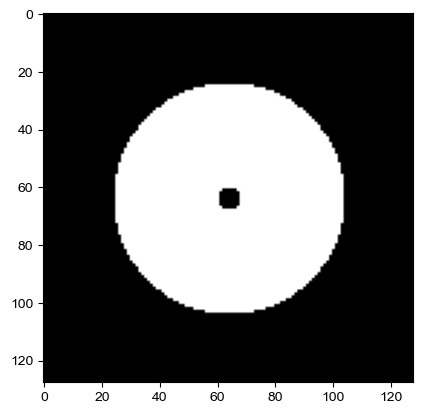

In [10]:
outr = 40
inr = 4
mask = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.float32)
rr, cc = disk((IMG_SIZE/2, IMG_SIZE/2), outr, shape = (IMG_SIZE, IMG_SIZE))
ss, dd = disk((IMG_SIZE/2, IMG_SIZE/2), inr, shape = (IMG_SIZE, IMG_SIZE))
mask[rr, cc] = 1
mask[ss, dd] = 0

plt.imshow(mask, cmap = 'gray')

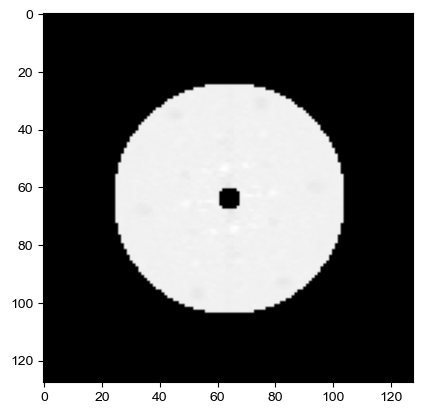

In [11]:
plt.imshow(mask*dCp_4D[0], cmap = 'gray')

In [12]:
dCp_map = []
for i in range(SET_SIZE):
    inte = (mask*dCp_4D[i]).sum()
    dCp_map.append(inte)
    
dcp_map = (np.asarray(dCp_map)).reshape(ScanX, ScanY)

<Figure size 1920x1440 with 0 Axes>

(-0.5, 314.5, 314.5, -0.5)

2058.1074

2060.3713

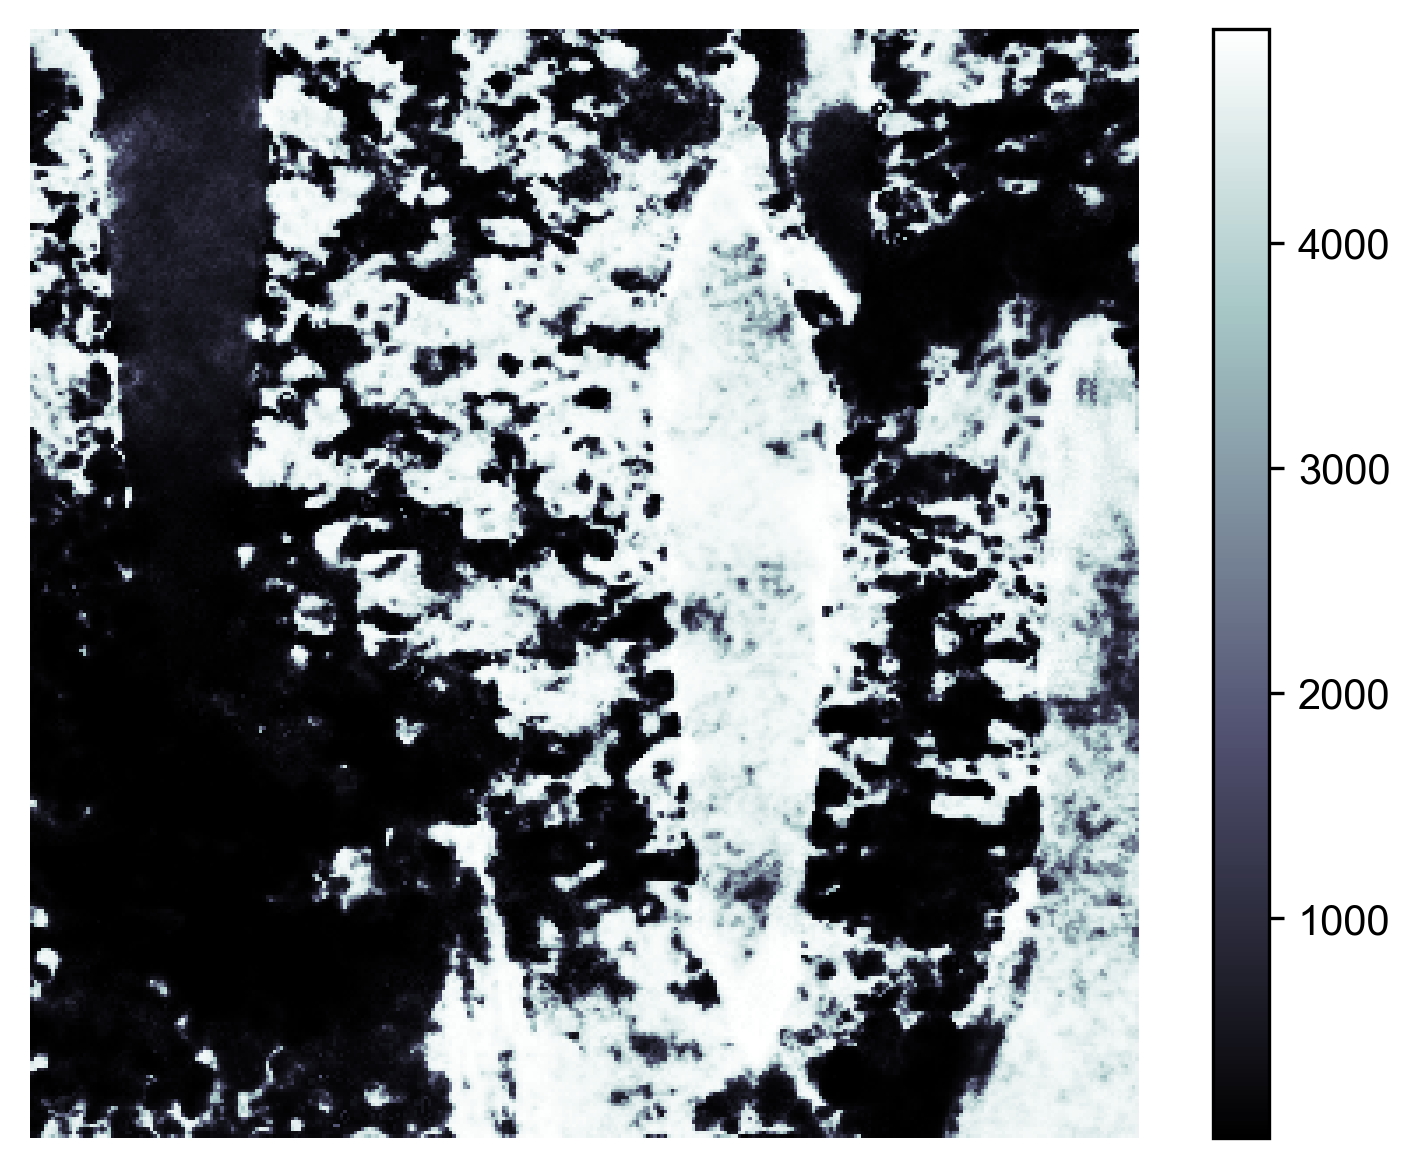

In [13]:
plt.figure(dpi = 300)
plt.imshow(dcp_map, cmap = 'bone')
plt.colorbar()
plt.axis('off')
dcp_map.mean()
dcp_map.std()

# NMF & Strain Mapping

In [10]:
%%time
nmf = skld.NMF(n_components=5, solver = 'mu', max_iter = 10000, init = None, random_state = 0)
sma_nmf = nmf.fit_transform(nbed_4D_flat)
nmf.n_iter_

CPU times: total: 16min 44s
Wall time: 3min 48s


240

In [ ]:
%%time
nmf2 = skld.NMF(n_components=4, solver = 'mu', max_iter = 10000, init = None, random_state = 0)
sma_cep_nmf = nmf2.fit_transform(cep_4D_flat)
nmf2.n_iter_

In [62]:
np.save('smaGanmf232-315', sma_nmf)
np.save('smaGanmfcep232-315', sma_cep_nmf)

In [9]:
sma_nmf = np.load('smaGanmf232-315.npy')
sma_cep_nmf = np.load('smaGanmfcep232-315.npy')

In [88]:
H = nmf2.components_

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

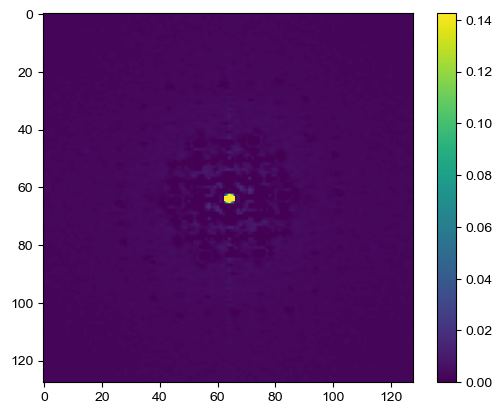

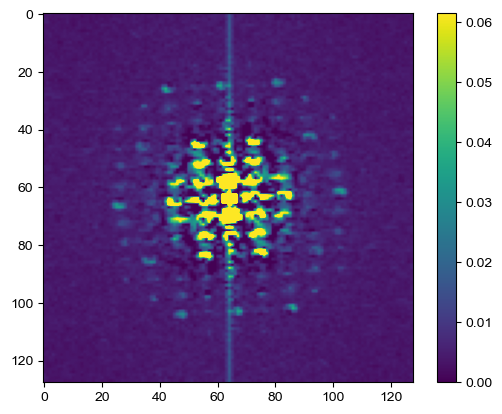

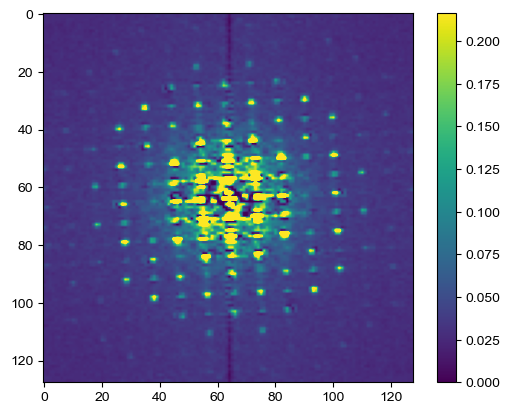

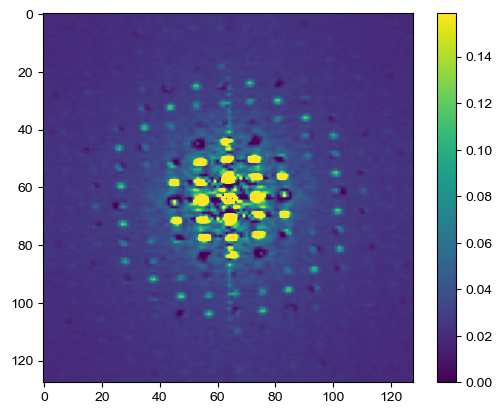

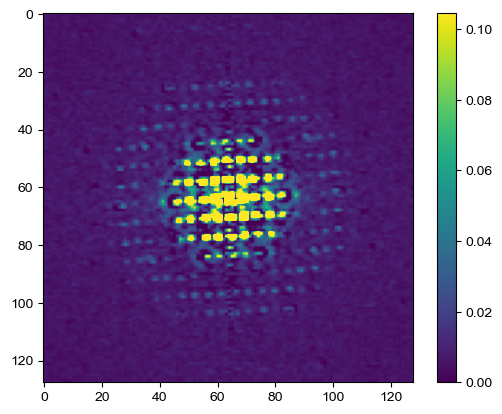

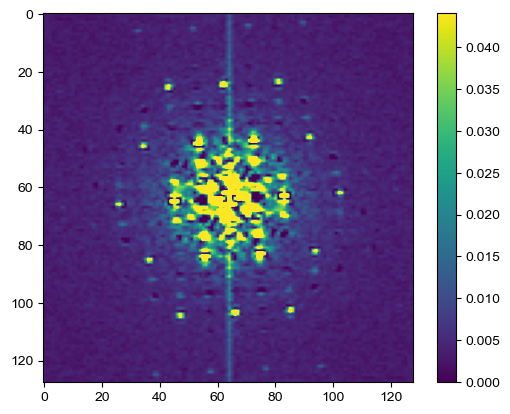

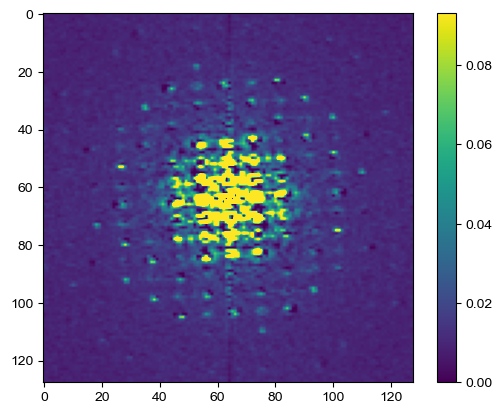

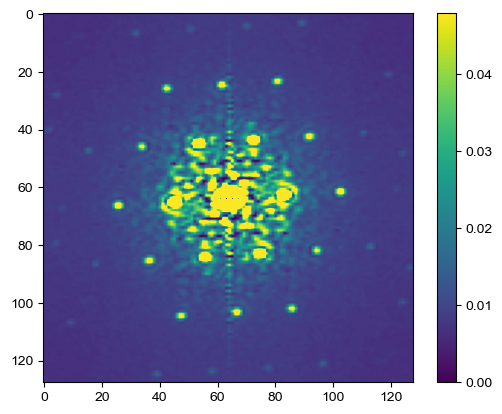

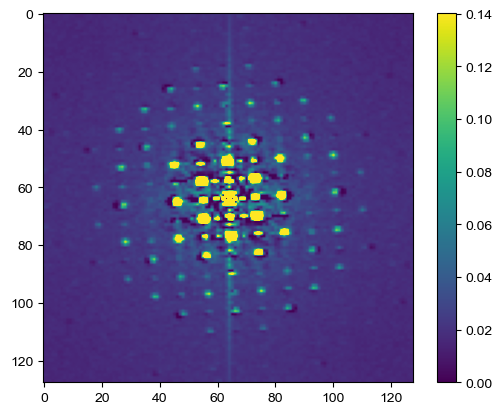

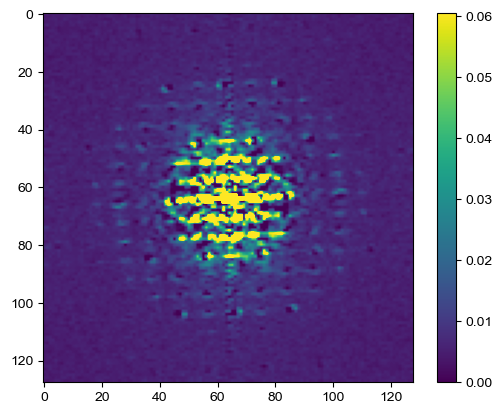

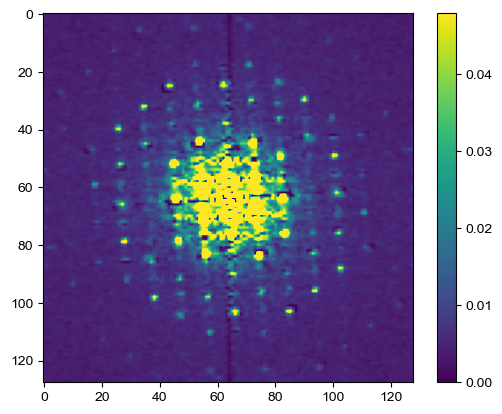

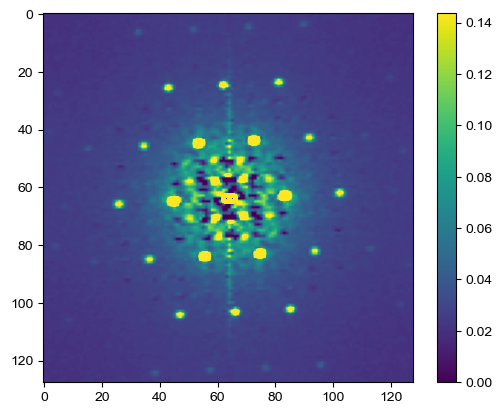

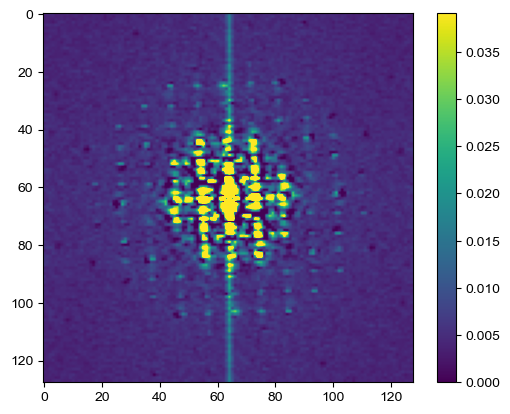

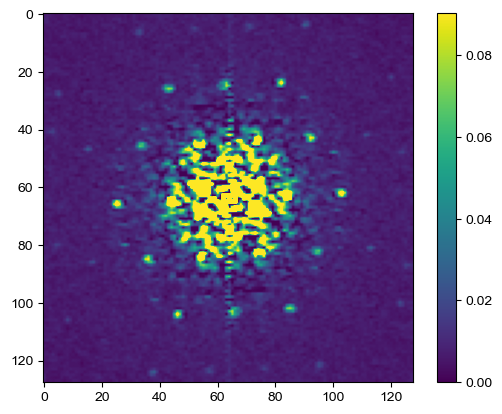

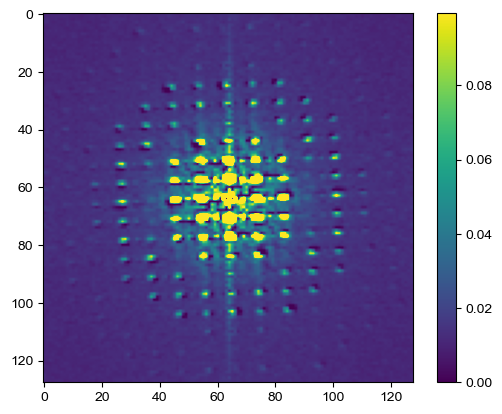

In [90]:
for i in range(len(H)):
    plt.figure()
    plt.imshow(H[i].reshape(IMG_SIZE, IMG_SIZE))
    plt.colorbar()
    plt.clim([0, H[i].mean() + H[i].std()])

In [20]:
rmse_nmf = []
best_n_nmf = 0
actual_rmse_nmf = 1000000
for i in range(1,10):
    temp_rmse = []
    for j in range(0,10):
        nmf_run = skld.NMF(n_components = i, max_iter = 200)
        nmf_run_fit = nmf_run.fit_transform(sma_nbed_flat)
        sma_nmf_rec_flat = (nmf_run.inverse_transform(nmf_run_fit))
        curr_rmse = mean_squared_error(sma_nbed_flat, sma_nmf_rec_flat, squared = False)
        temp_rmse.append(curr_rmse)
    avg_rmse = np.asarray(temp_rmse).mean()
    rmse_nmf.append(np.asarray(avg_rmse).mean())
    if avg_rmse < actual_rmse_nmf:
        actual_rmse_nmf = avg_rmse
        best_n_nmf = i
    else:
        actual_rmse_nmf = actual_rmse_nmf
        best_n_nmf = best_n_nmf
    

C:\Users\kimlab\miniconda3\envs\USML\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
C:\Users\kimlab\miniconda3\envs\USML\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\kimlab\miniconda3\envs\USML\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
C:\Users\kimlab\miniconda3\envs\USML\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\kimlab\minico

C:\Users\kimlab\miniconda3\envs\USML\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
C:\Users\kimlab\miniconda3\envs\USML\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\kimlab\miniconda3\envs\USML\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
C:\Users\kimlab\miniconda3\envs\USML\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\kimlab\minico

C:\Users\kimlab\miniconda3\envs\USML\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
C:\Users\kimlab\miniconda3\envs\USML\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
C:\Users\kimlab\miniconda3\envs\USML\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
C:\Users\kimlab\miniconda3\envs\USML\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_compo

C:\Users\kimlab\miniconda3\envs\USML\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\kimlab\miniconda3\envs\USML\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
C:\Users\kimlab\miniconda3\envs\USML\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\kimlab\miniconda3\envs\USML\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
C:\Users\kimlab\minico

C:\Users\kimlab\miniconda3\envs\USML\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\kimlab\miniconda3\envs\USML\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
C:\Users\kimlab\miniconda3\envs\USML\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\kimlab\miniconda3\envs\USML\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
C:\Users\kimlab\minico

In [48]:
#np.save('rmse_nmf', np.array(rmse_nmf))
rmse_nmf = np.load('rmse_nmf.npy')

<Figure size 3840x2880 with 0 Axes>

([<matplotlib.axis.XTick at 0x1f49dbf7250>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9')])

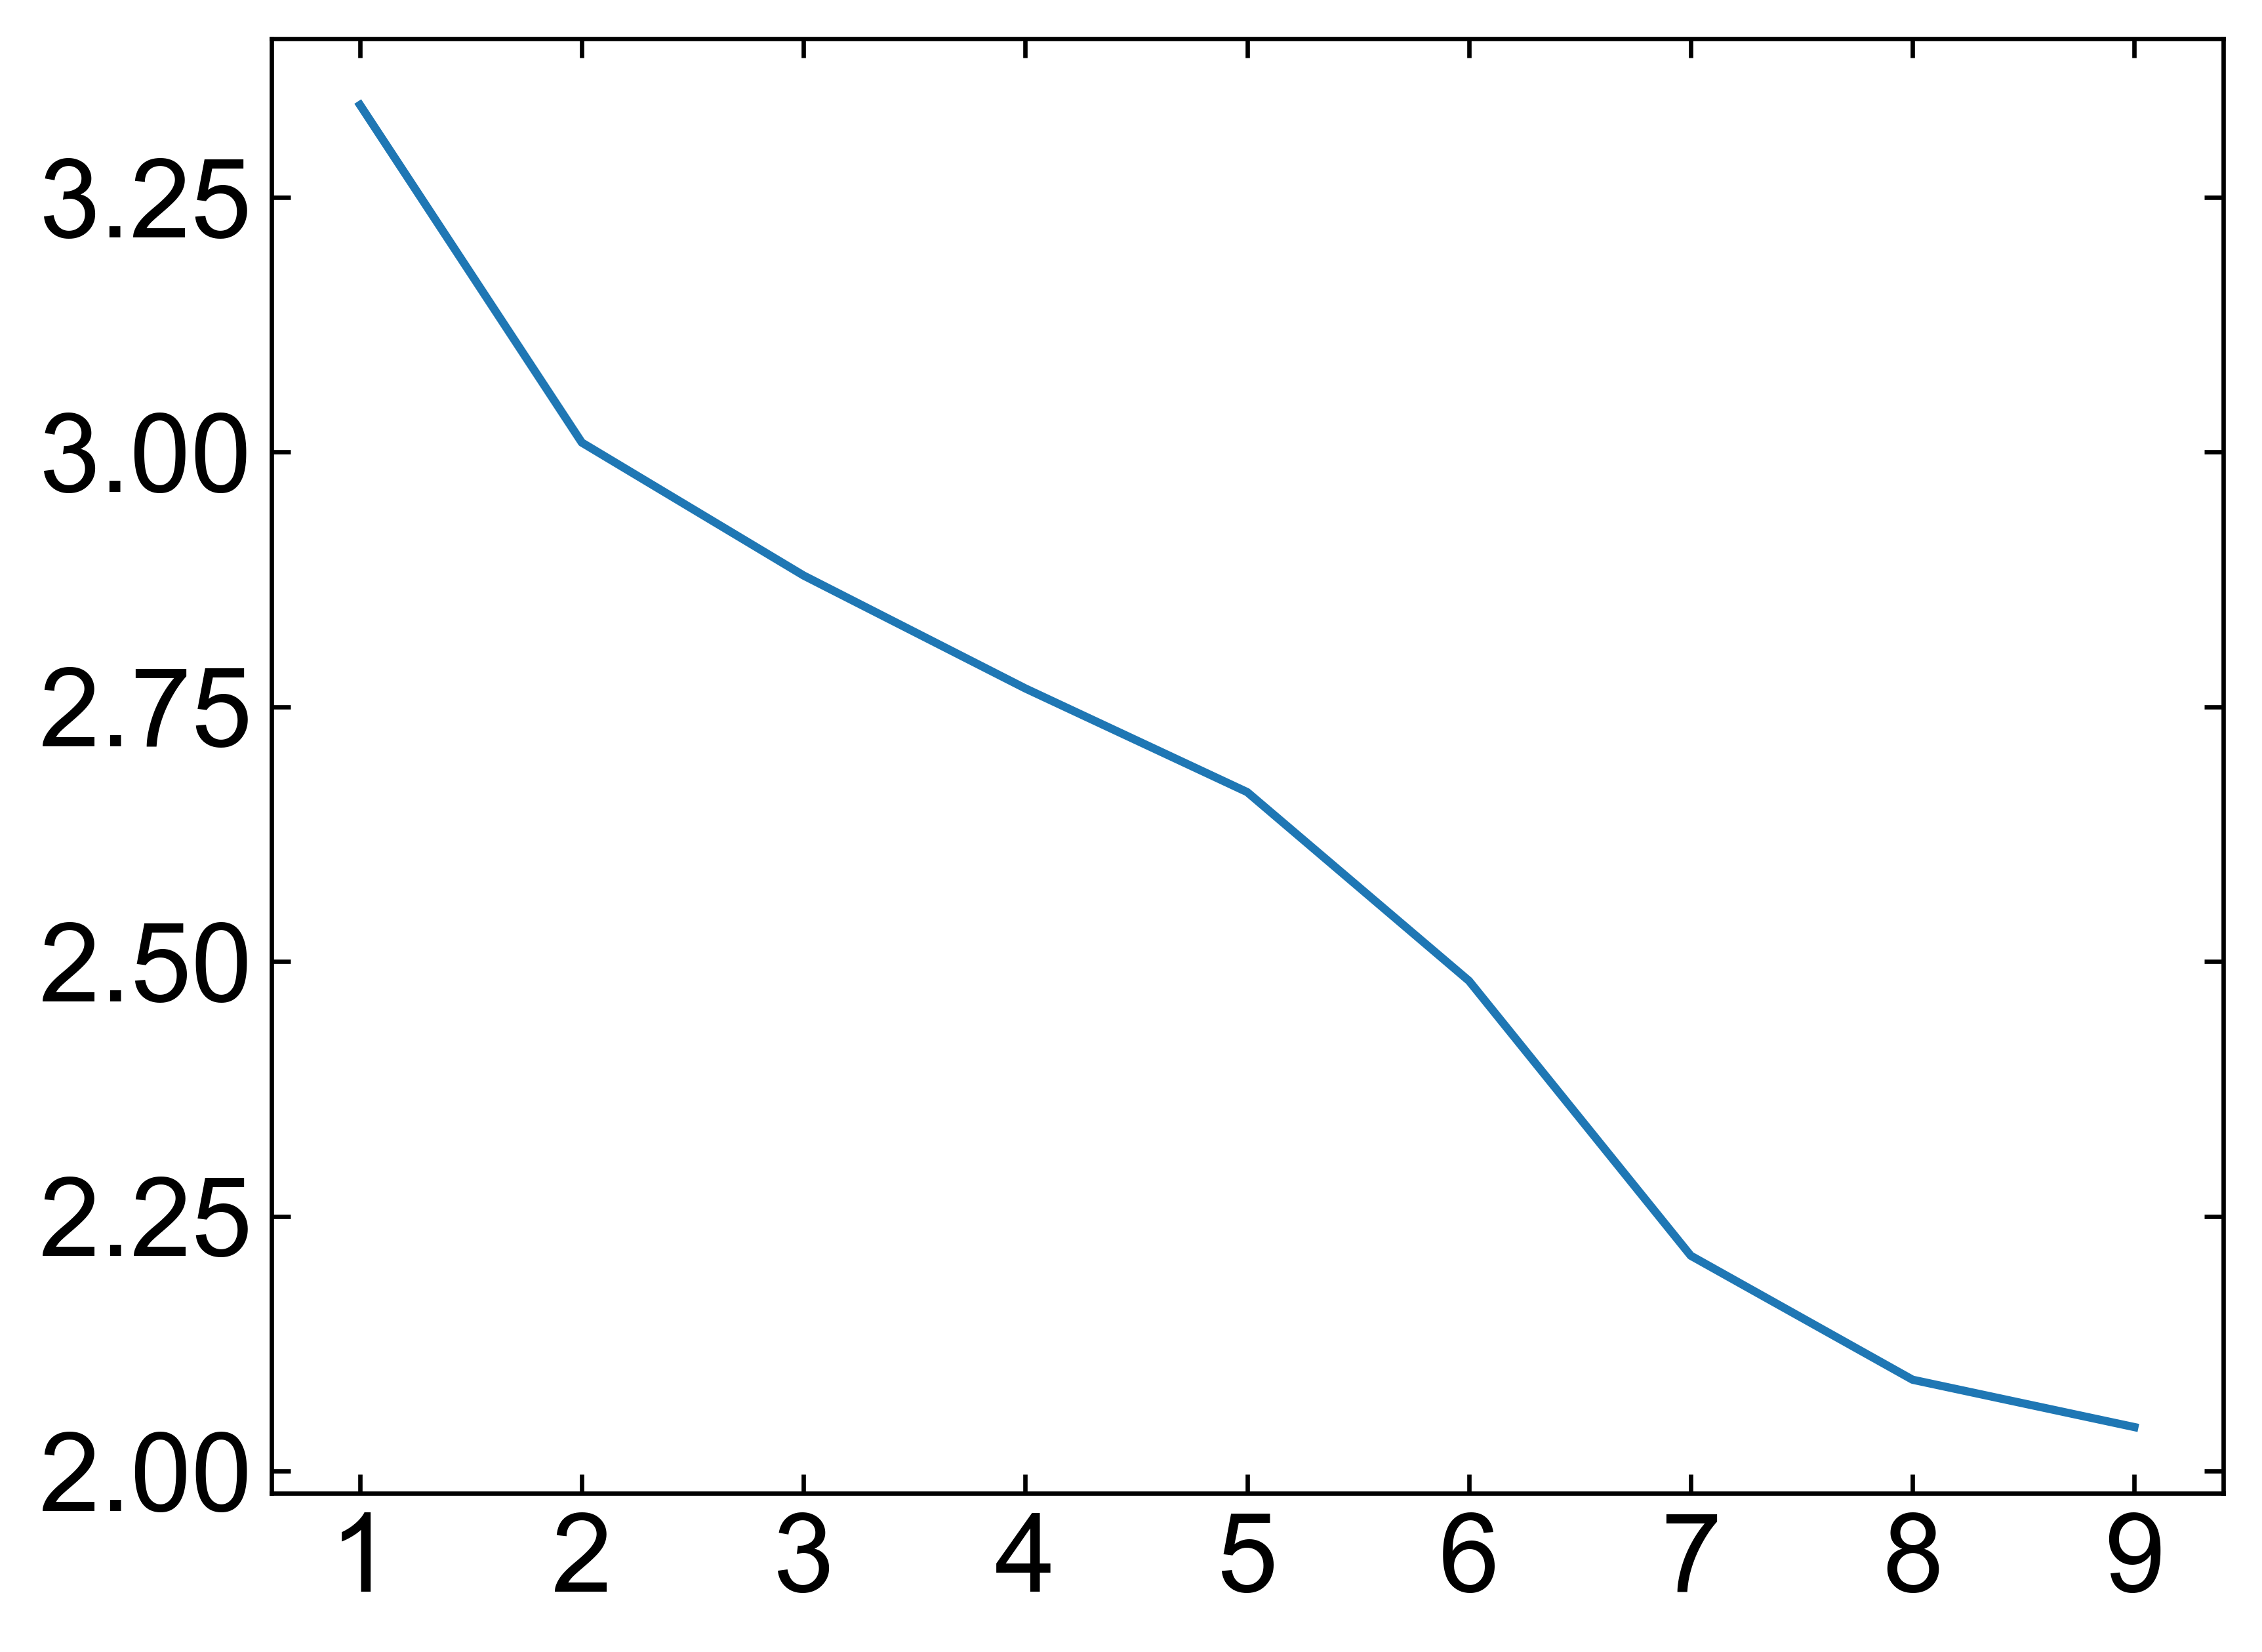

In [340]:
plt.figure(dpi = 600)
x = np.arange(1,10,1)
plt.tick_params(axis = 'both', direction = 'in', top = True, right = True, labelsize = 20)
plt.plot(x, rmse_nmf*1000)
plt.xticks(x, x)

In [194]:
kn_inertia = []
for i in range(2, 12):
    temp_inertia = []
    for j in range(0,10):
        kmeans_nmf_run = KMeans(n_clusters = i).fit(sma_nmf)
        temp_inertia.append(kmeans_nmf_run.inertia_)
    kn_inertia.append(np.asarray(temp_inertia).mean())
    

In [195]:
kn_inertia = np.asarray(kn_inertia)
kn_inertia.mean()

455.3705

<Figure size 3840x2880 with 0 Axes>

([<matplotlib.axis.XTick at 0x2382fe336a0>,
 [Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10')])

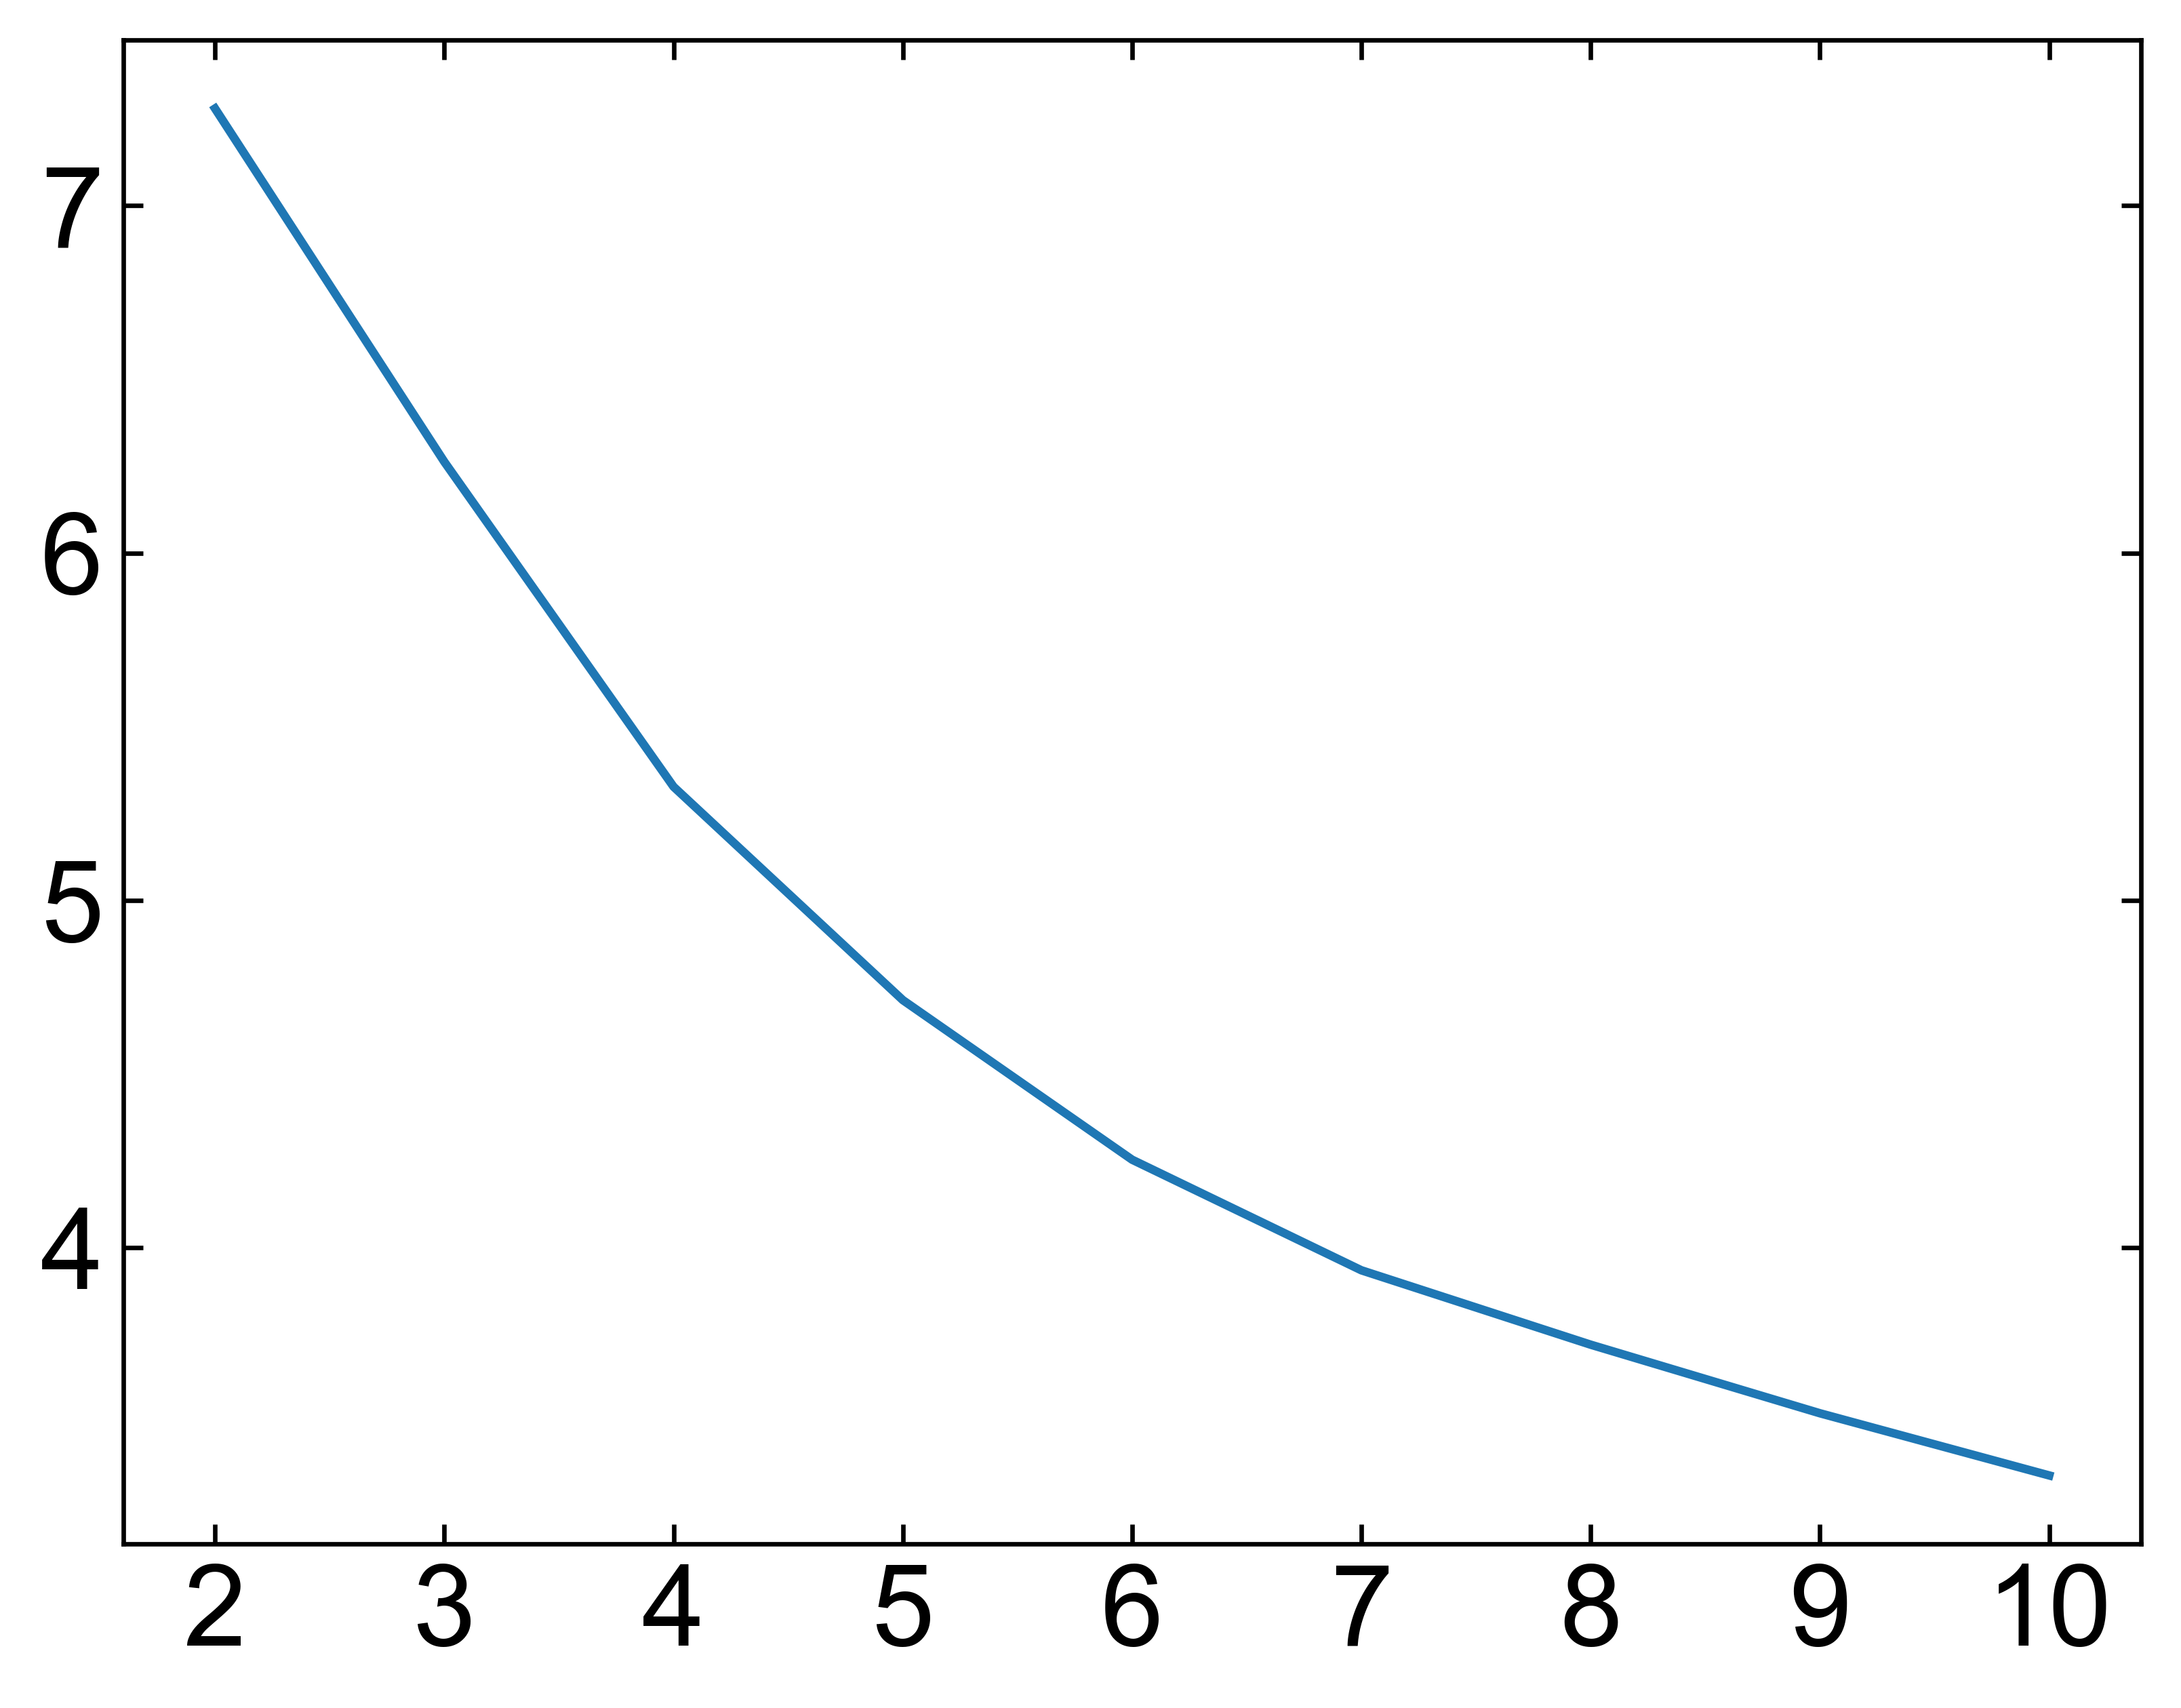

In [196]:
plt.figure(dpi = 600)
plt.tick_params(axis = 'both', direction = 'in', top = True, right = True, labelsize = 20)
n = np.arange(2,12,1)
plt.plot(n[0:9], kn_inertia[0:9]/100)
plt.xticks(n[0:9],n[0:9])

In [50]:
%%time
rmse_nmf_cep = []
best_n_nmfcep = 0
actual_rmse_nmfcep = 1000000
for i in range(2,10):
    temp_rmse = []
    for j in range(0,10):
        nmf_run = skld.NMF(n_components = i, solver = 'mu', max_iter = 1000)
        nmf_run_fit = nmf_run.fit_transform(cep_4D_flat)
        sma_nmf_rec_flat = (nmf_run.inverse_transform(nmf_run_fit))
        curr_rmse = mean_squared_error(cep_4D_flat, sma_nmf_rec_flat, squared = False)
        temp_rmse.append(curr_rmse)
    avg_rmse = np.asarray(temp_rmse).mean()
    rmse_nmf_cep.append(np.asarray(avg_rmse).mean())
    if avg_rmse < actual_rmse_nmfcep:
        actual_rmse_nmfcep = avg_rmse
        best_n_nmfcep = i
    else:
        actual_rmse_nmfcep = actual_rmse_nmfcep
        best_n_nmfcep = best_n_nmfcep
    

CPU times: total: 2d 17h 13min 51s
Wall time: 14h 26min 41s


In [51]:
np.save('rmse_nmf_cep', np.array(rmse_nmf_cep))
#rmse_nmf_cep = np.load('rmse_nmf_cep.npy')

([<matplotlib.axis.XTick at 0x238be6bd480>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8')])

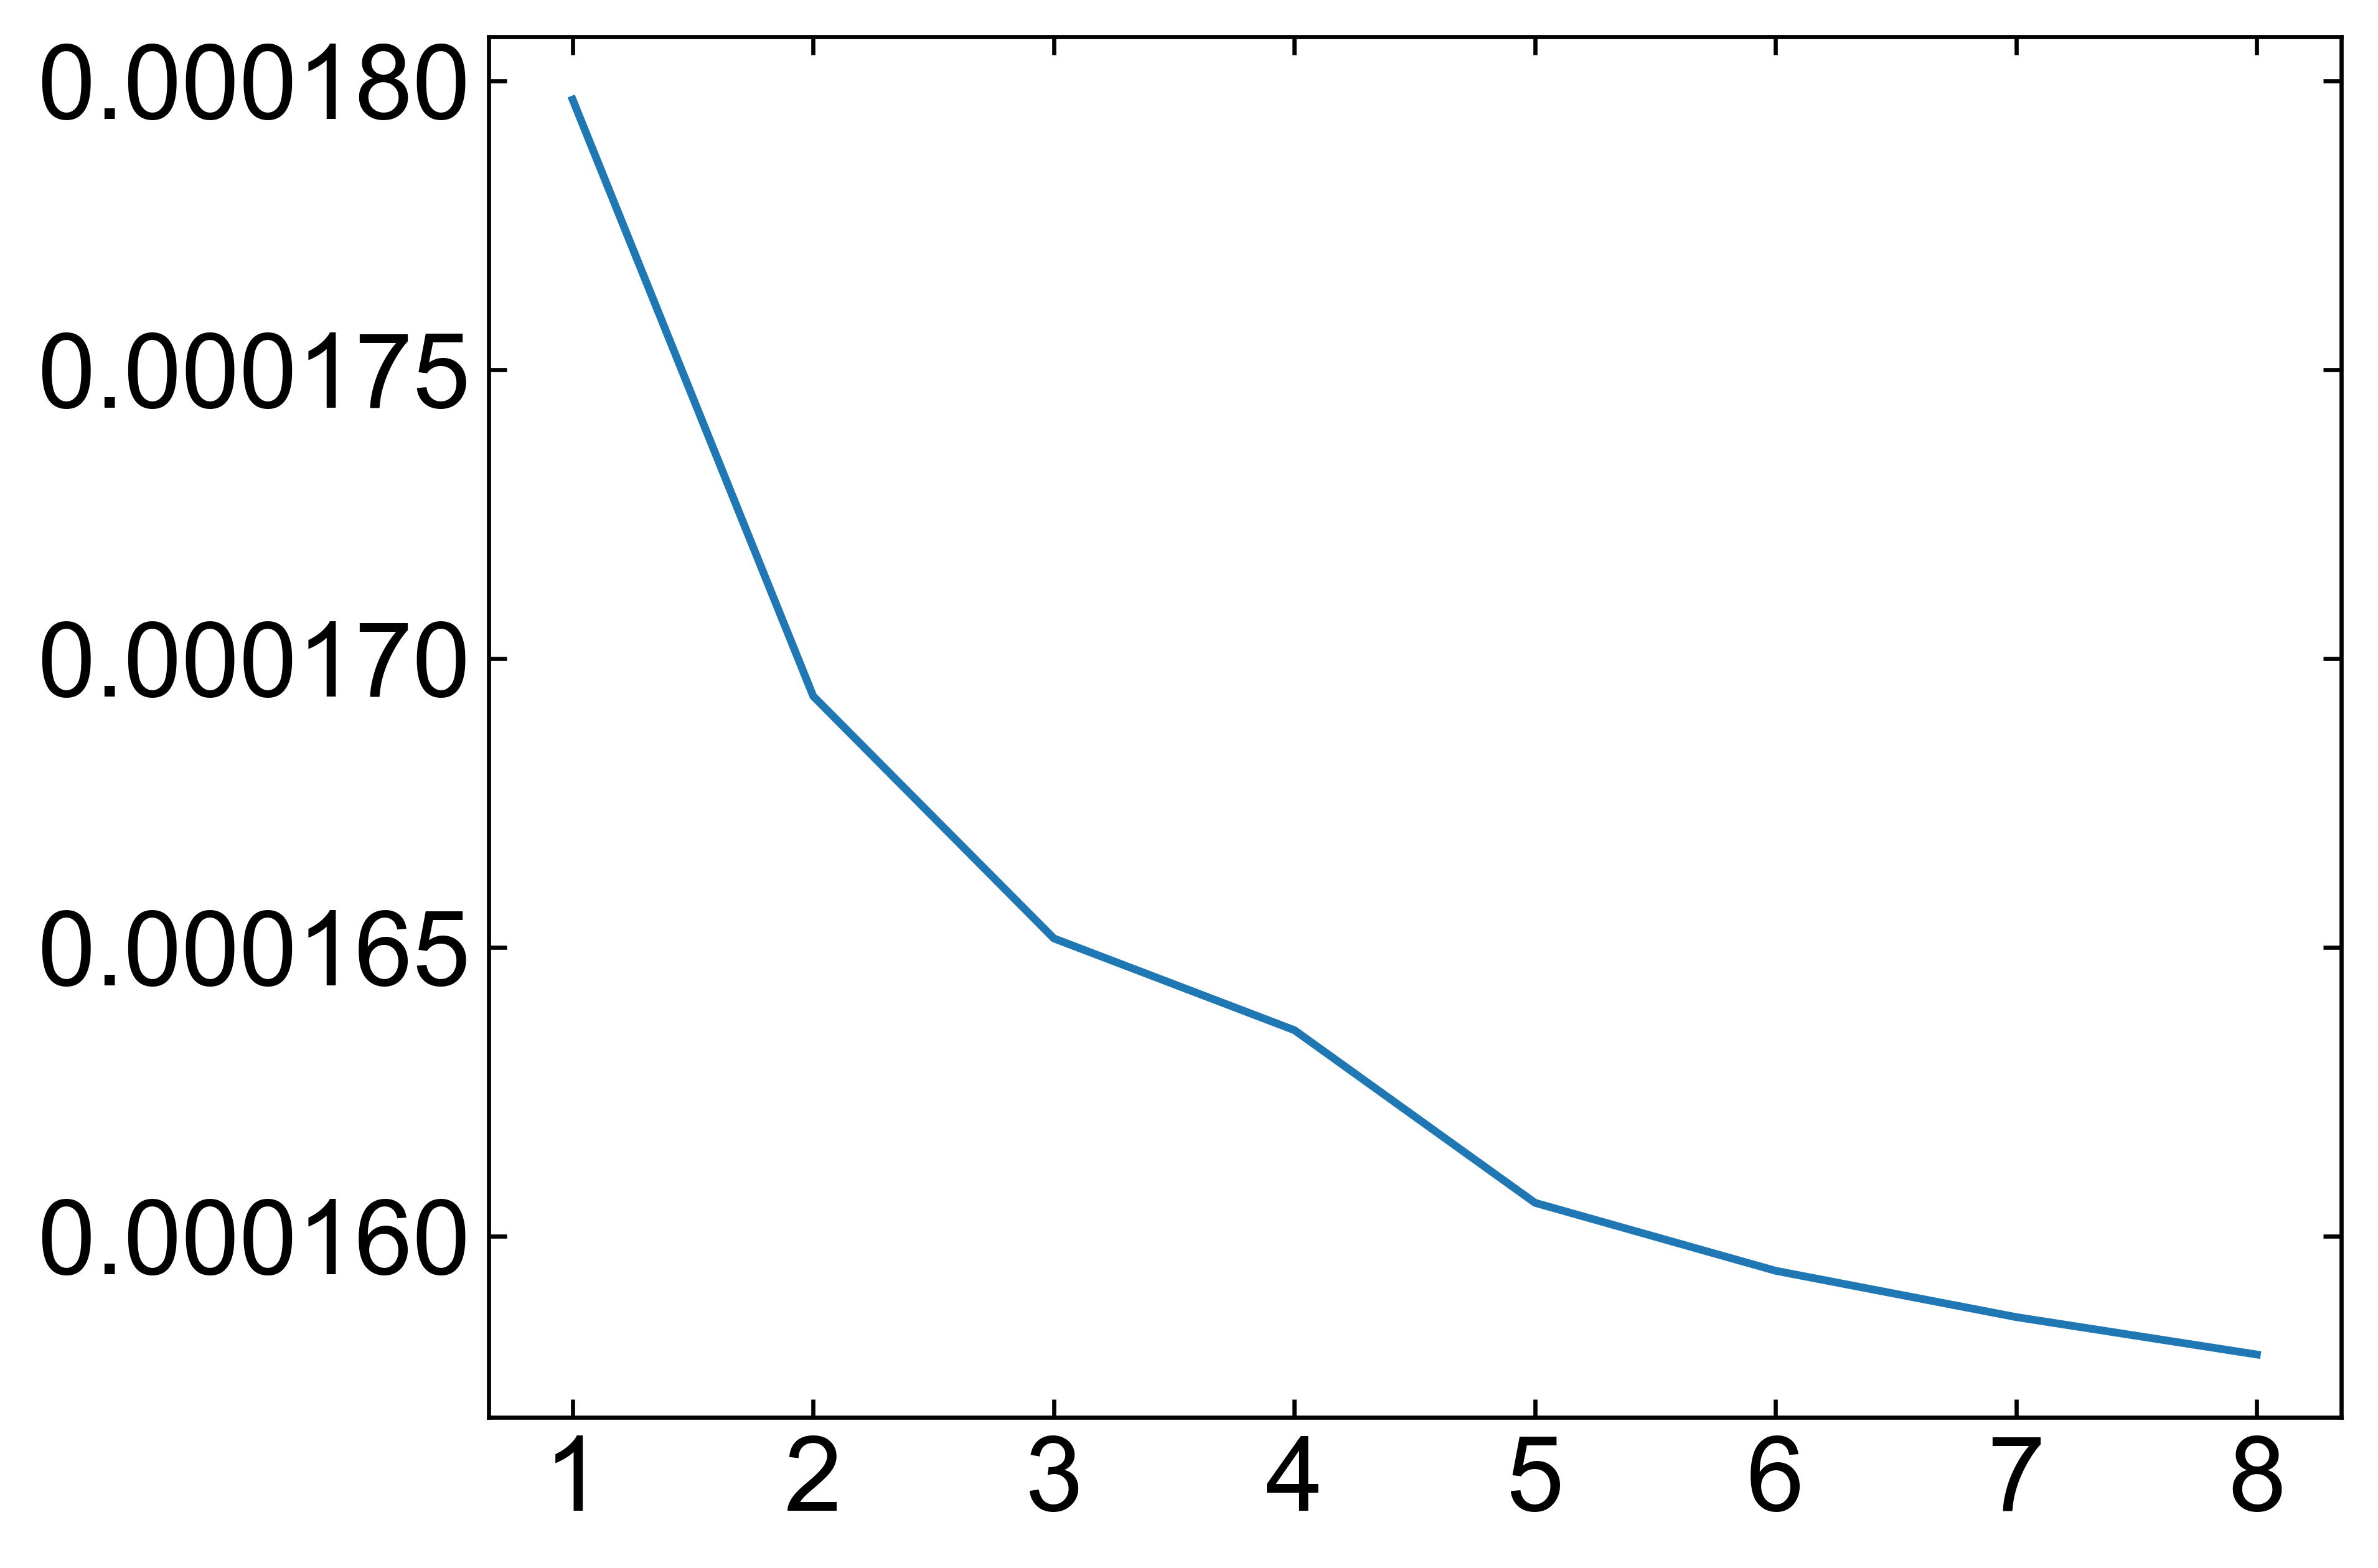

In [55]:
x = np.arange(1,9,1)
fig, ax = plt.subplots(1, 1, dpi = 600)
ax.plot(x, rmse_nmf_cep)
ax.tick_params(axis = 'both', direction = 'in', top = True, right = True, labelsize = 20)
plt.xticks(x,x)

In [65]:
kcn_inertia = []
for i in range(2, 12):
    temp_inertia = []
    for j in range(0,10):
        kmeans_cep_nmf_run = KMeans(n_clusters = i, n_init = 10).fit(sma_cep_nmf[:])
        temp_inertia.append(kmeans_cep_nmf_run.inertia_)
    kcn_inertia.append(np.asarray(temp_inertia).mean())
    

In [66]:
kcn_inertia = np.asarray(kcn_inertia)
kcn_inertia.mean()

5.239774

<Figure size 3840x2880 with 0 Axes>

([<matplotlib.axis.XTick at 0x23a5061bdc0>,
 [Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10')])

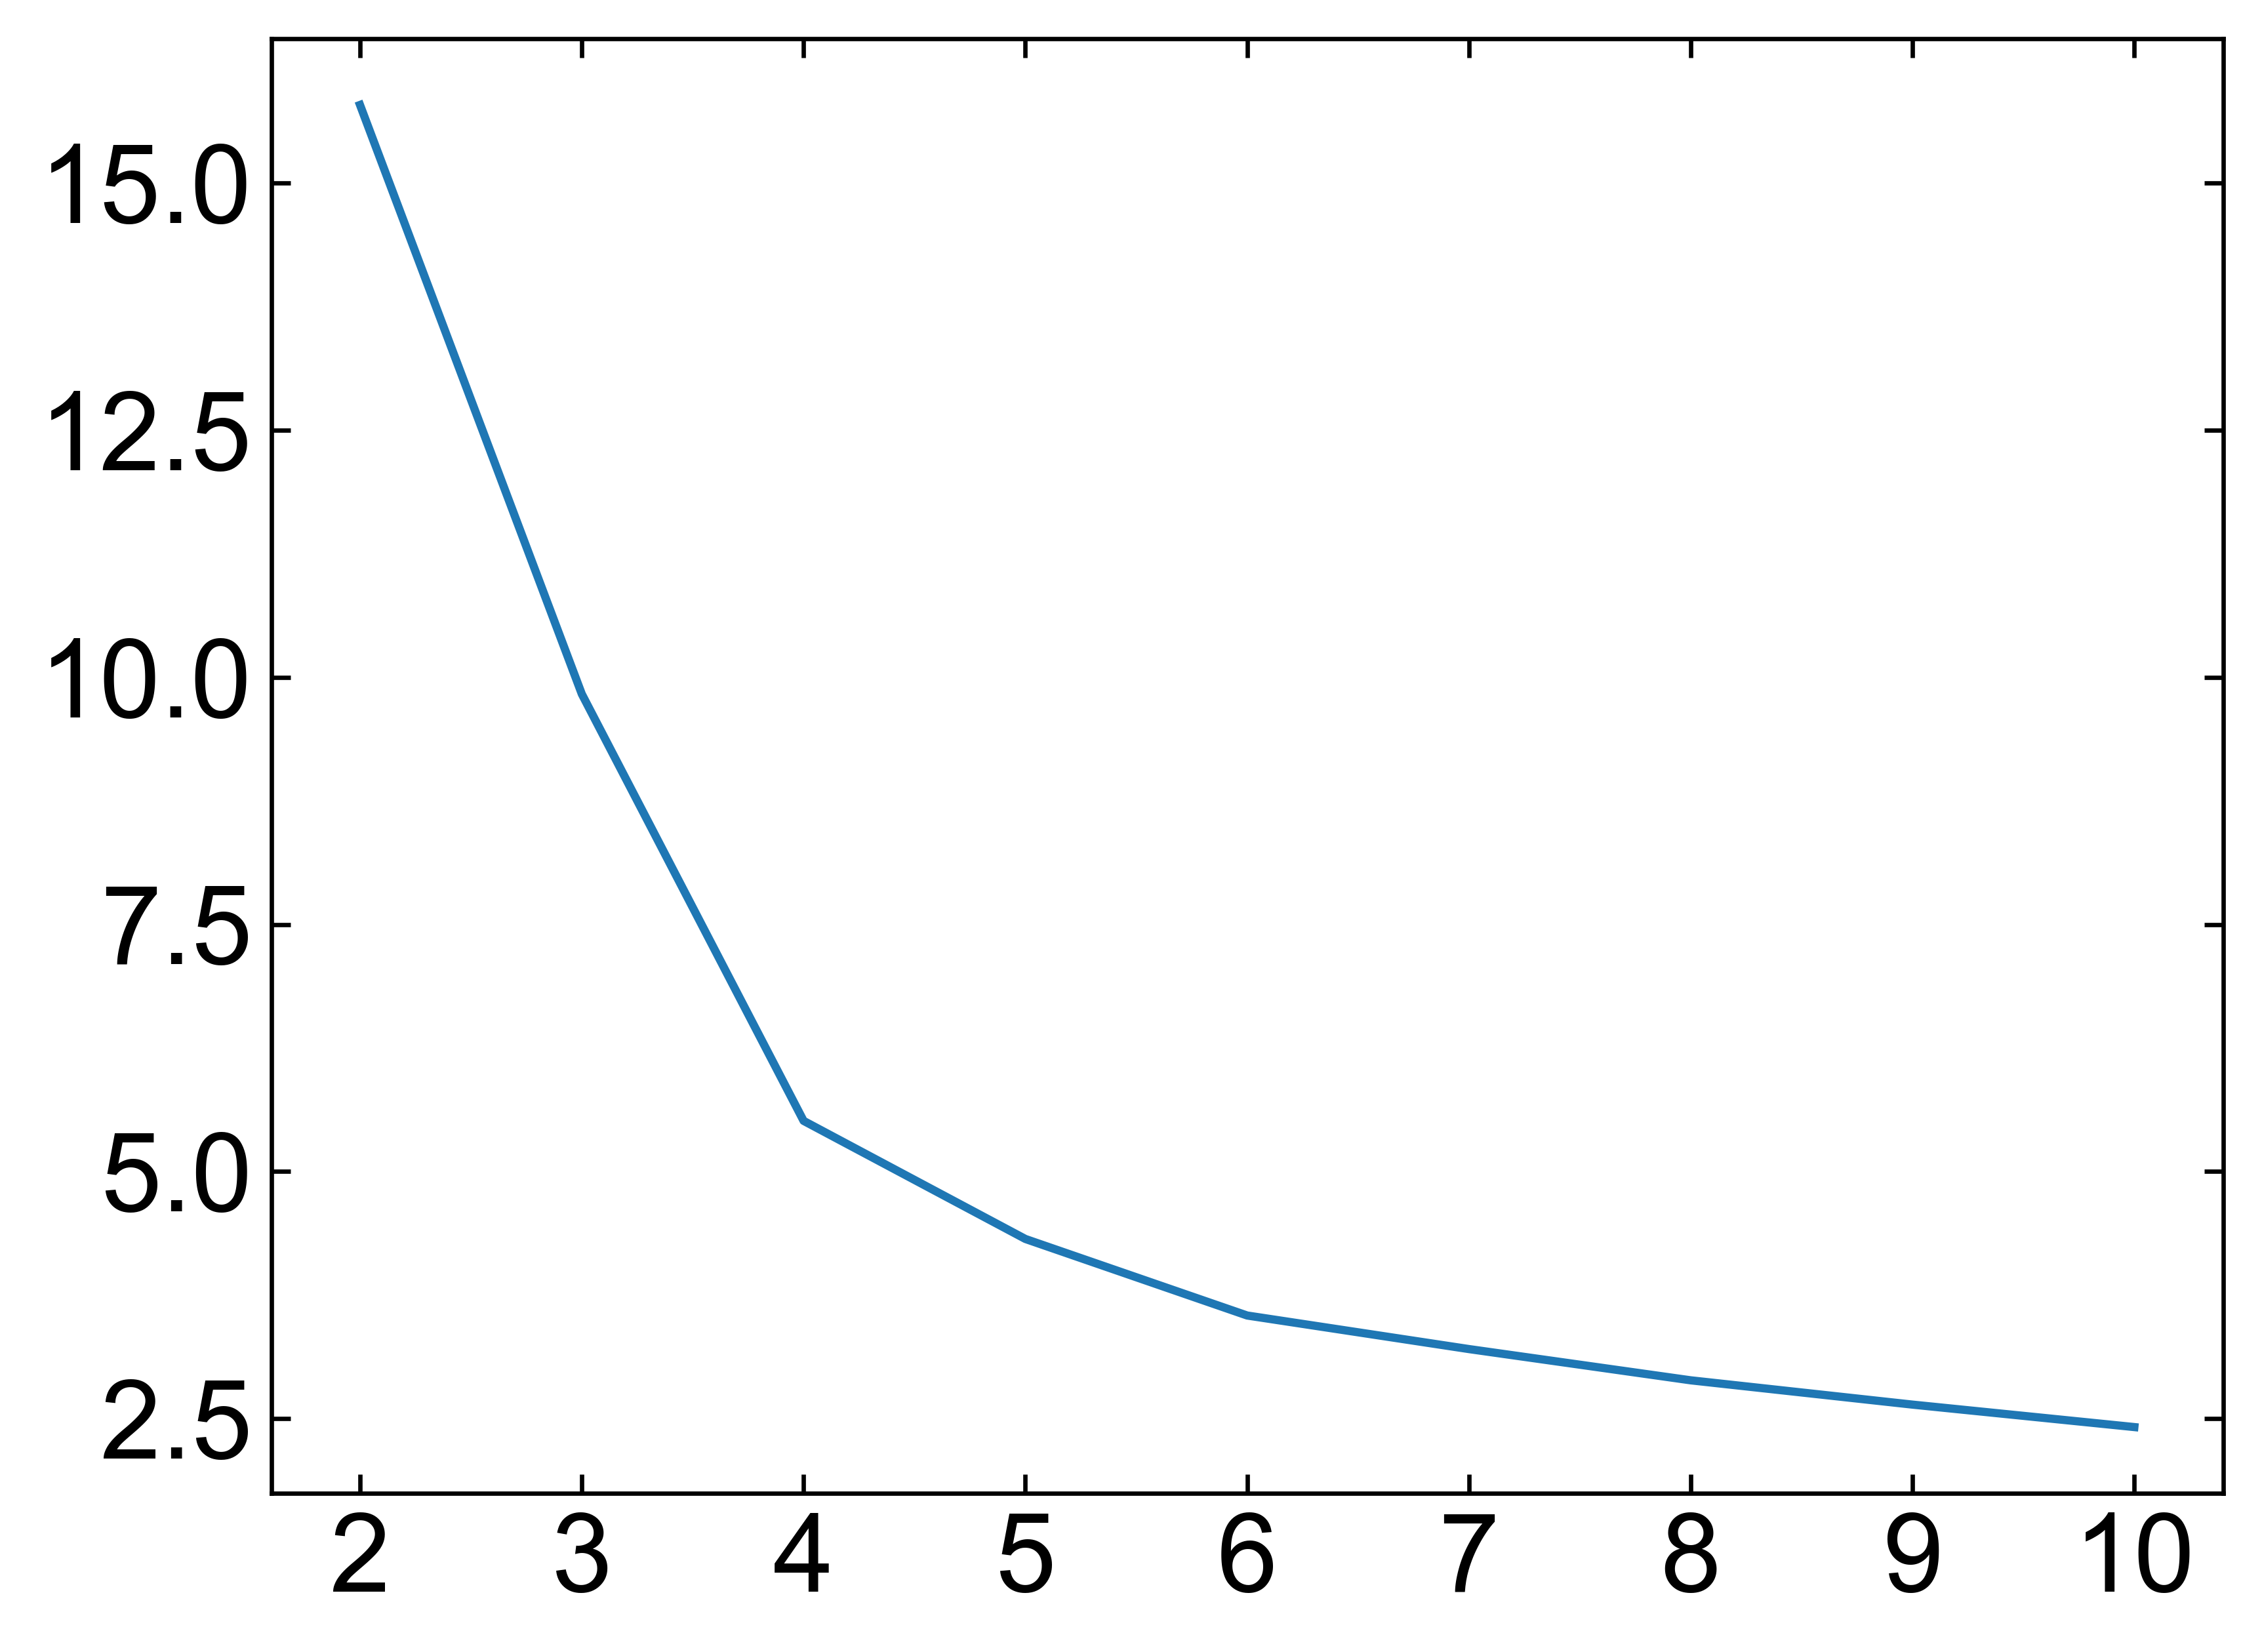

In [67]:
plt.figure(dpi = 600)
plt.tick_params(axis = 'both', direction = 'in', top = True, right = True, labelsize = 20)
n = np.arange(2,12,1)
plt.plot(n[0:9], kcn_inertia[0:9])
plt.xticks(n[0:9],n[0:9])

<Figure size 1920x1440 with 0 Axes>

C:\Users\kimlab\AppData\Local\Temp\ipykernel_21252\577021032.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.imshow(cluster_map_nmf, cmap = cm.get_cmap('PuOr', nckn))


(-0.5, 314.5, 314.5, -0.5)

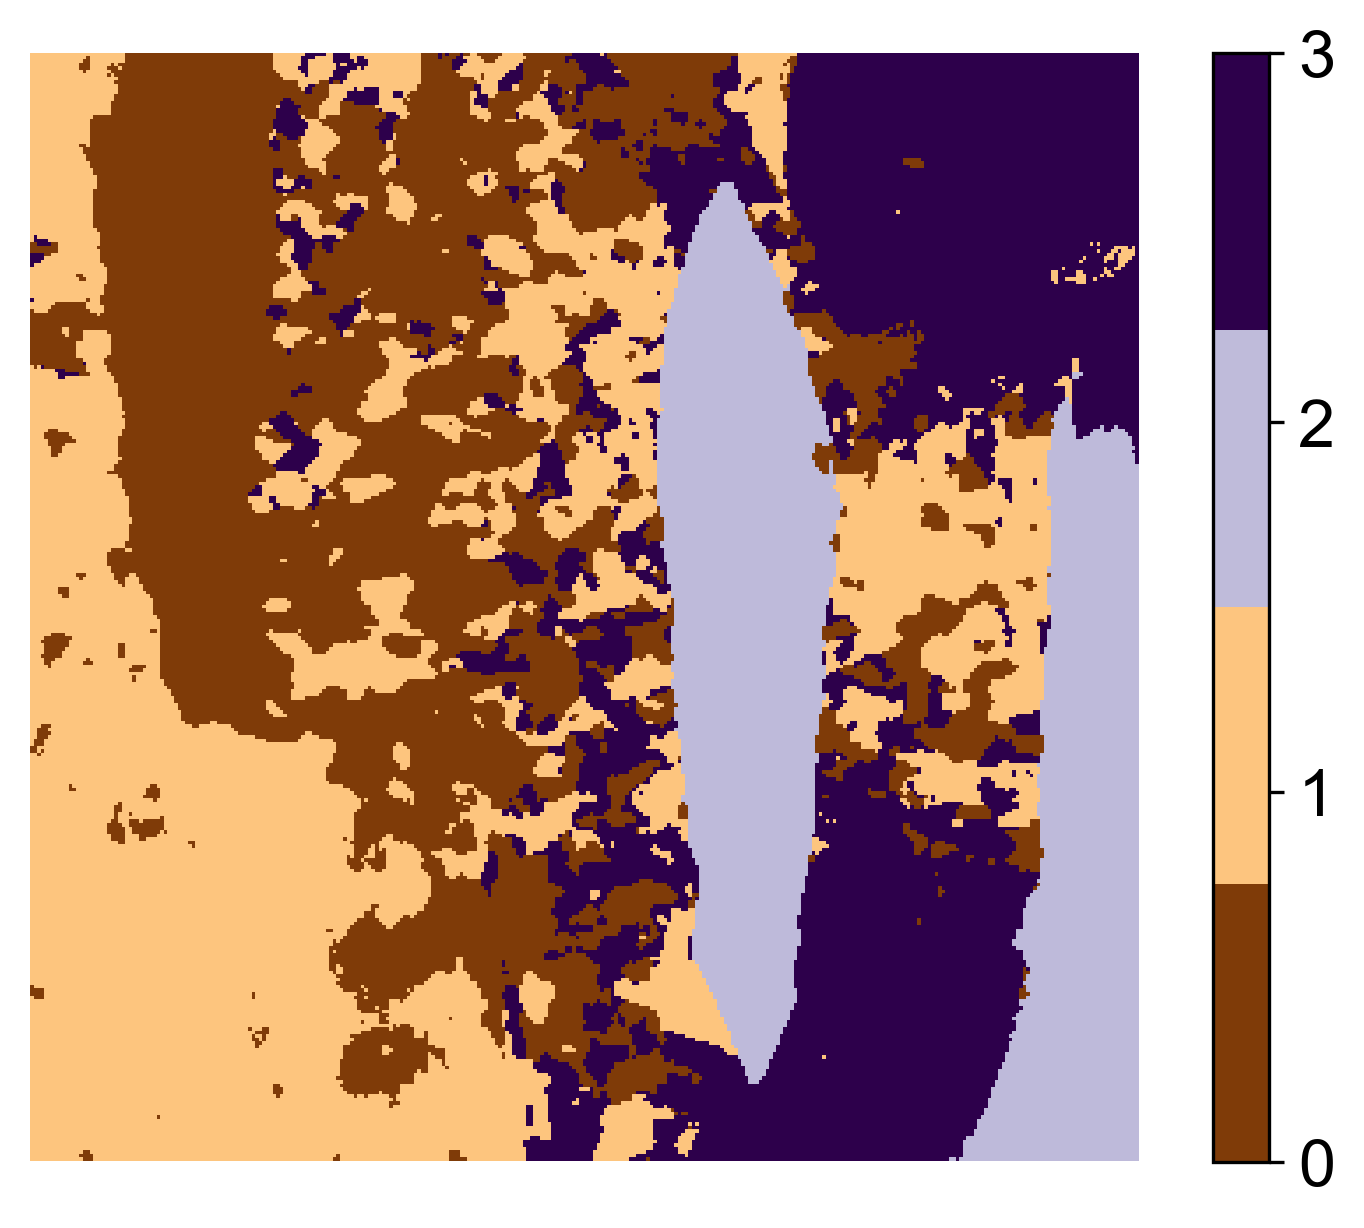

In [12]:
nckn = 4
kmeans_nmf = KMeans(n_clusters = nckn, n_init = 10).fit(sma_nmf[:,:]) # k = # of clusters

plt.figure(dpi = 300)
cluster_map_nmf = (np.reshape(kmeans_nmf.labels_, (ScanX, ScanY)))
plt.imshow(cluster_map_nmf, cmap = cm.get_cmap('PuOr', nckn))
plt.colorbar(ticks = np.arange(nckn)).ax.tick_params(labelsize = 16)
plt.axis('off')

<Figure size 1920x1440 with 0 Axes>

C:\Users\kimlab\AppData\Local\Temp\ipykernel_21252\680780653.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.imshow(cluster_map_cep_nmf, cmap = cm.get_cmap('RdYlBu',ncknc))


(-0.5, 314.5, 314.5, -0.5)

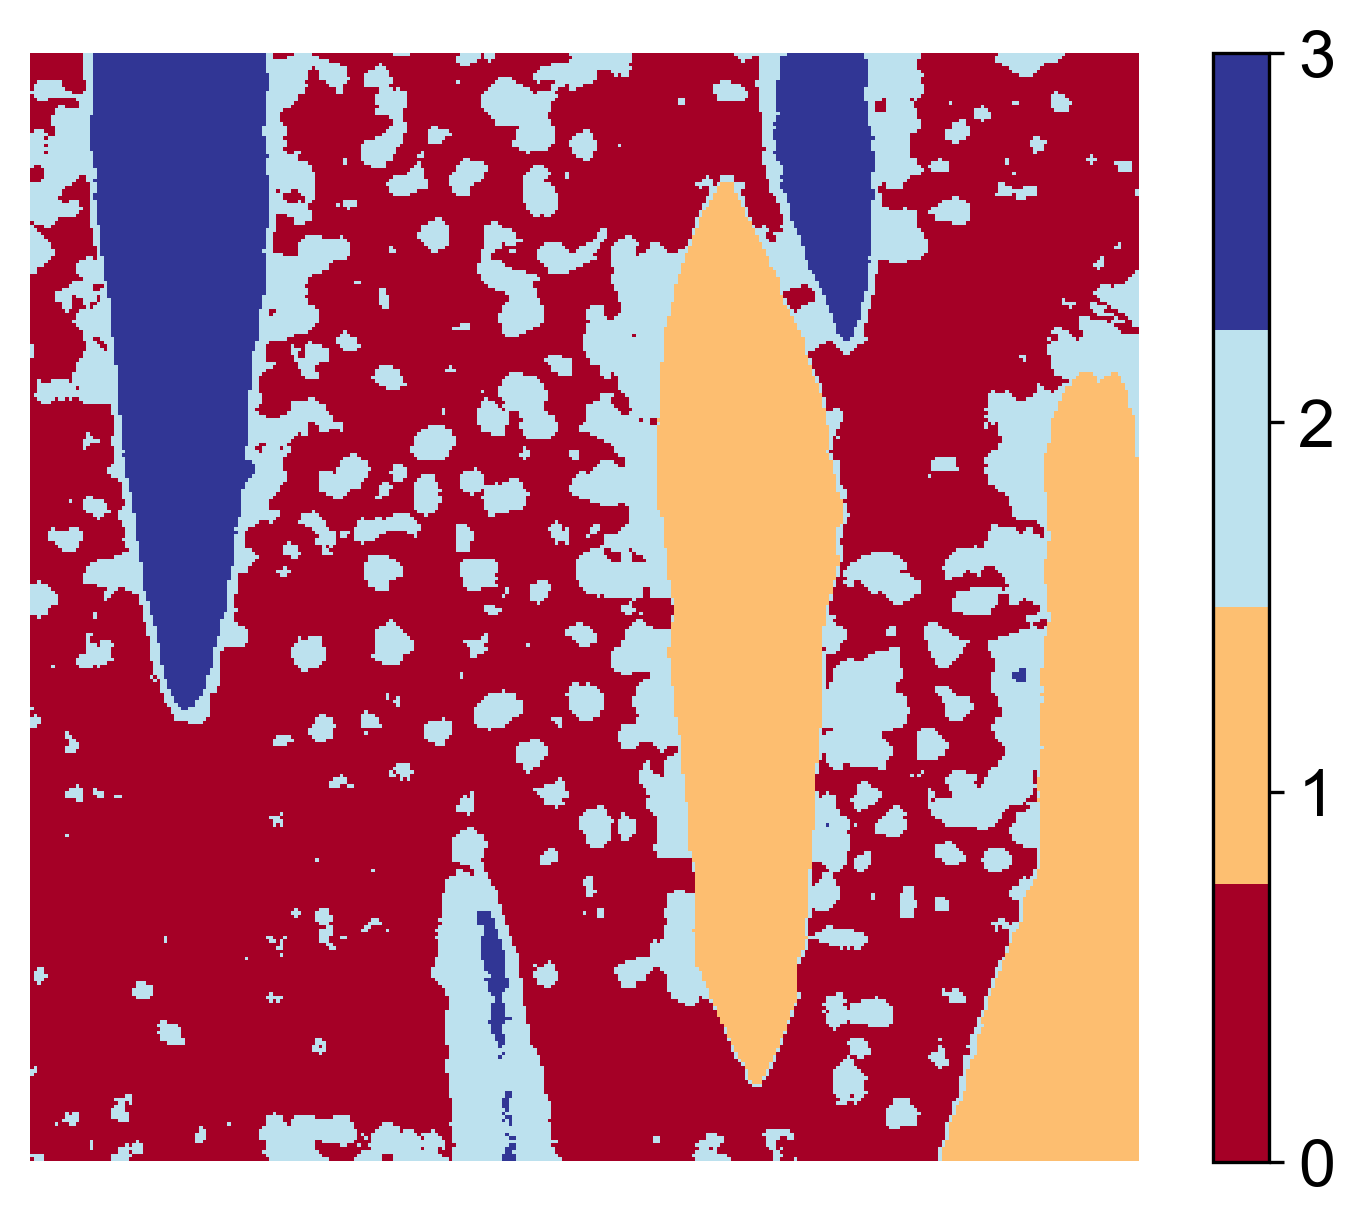

In [100]:
ncknc = 4
kmeans_cep_nmf = KMeans(n_clusters = ncknc, n_init = 10).fit(sma_cep_nmf[:,:]) # k = # of clusters
plt.figure(dpi = 300)
cluster_map_cep_nmf = (np.reshape(kmeans_cep_nmf.labels_, (ScanX, ScanY)))
plt.imshow(cluster_map_cep_nmf, cmap = cm.get_cmap('RdYlBu',ncknc))
plt.colorbar(ticks = np.arange(ncknc)).ax.tick_params(labelsize = 16)
plt.axis('off')

In [101]:
cep_nmf_avg_dict = {}
nmf_avg_dict = {}
for x in range(ncknc):
    cep_nmf_avg_dict["nbed_{0}_avg_cep_nmf".format(x)] = get_avg_dp(kmeans_cep_nmf.labels_, x, cep_4D_flat.reshape(SET_SIZE,IMG_SIZE,IMG_SIZE))
for x in range(ncknc):
    nmf_avg_dict["nbed_{0}_avg_nmf".format(x)] = get_avg_dp(kmeans_cep_nmf.labels_, x, nbed_4D_flat.reshape(SET_SIZE,IMG_SIZE, IMG_SIZE))

(-0.5, 127.5, 127.5, -0.5)

Text(0.5, 1.0, 'Cluster 0 NBED')

(-0.5, 127.5, 127.5, -0.5)

Text(0.5, 1.0, 'Cluster 1 NBED')

(-0.5, 127.5, 127.5, -0.5)

Text(0.5, 1.0, 'Cluster 2 NBED')

(-0.5, 127.5, 127.5, -0.5)

Text(0.5, 1.0, 'Cluster 3 NBED')

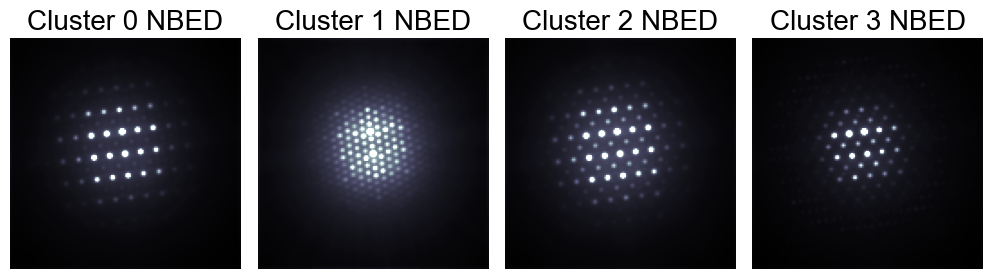

In [102]:
clim_ref2 = nmf_avg_dict["nbed_1_avg_nmf"]
n_max = clim_ref2.mean() + 4*clim_ref2.std()
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (12,3))
im1 = ax1.imshow(nmf_avg_dict["nbed_0_avg_nmf"], cmap = 'bone', vmin = 0, vmax = n_max)
ax1.axis('off')
ax1.set_title('Cluster 0 NBED', fontsize = 20)
im2 = ax2.imshow(nmf_avg_dict["nbed_1_avg_nmf"], cmap = 'bone', vmin = 0, vmax = n_max)
ax2.axis('off')
ax2.set_title('Cluster 1 NBED', fontsize = 20)
im3 = ax3.imshow(nmf_avg_dict["nbed_2_avg_nmf"], cmap = 'bone', vmin = 0, vmax = n_max)
ax3.axis('off')
ax3.set_title('Cluster 2 NBED', fontsize = 20)
im4 = ax4.imshow(nmf_avg_dict["nbed_3_avg_nmf"], cmap = 'bone', vmin = 0, vmax = n_max)
ax4.axis('off')
ax4.set_title('Cluster 3 NBED', fontsize = 20)
# im5 = ax5.imshow(nmf_avg_dict["nbed_4_avg_nmf"], cmap = 'bone', vmin = 0, vmax = n_max)
# ax5.axis('off')
# ax5.set_title('Cluster 4 NBED', fontsize = 25)
# im6 = ax6.imshow(nmf_avg_dict["nbed_5_avg_nmf"], cmap = 'bone', vmin = 0, vmax = n_max)
# ax6.axis('off')
# ax6.set_title('Cluster 5 NBED', fontsize = 25)

fig.subplots_adjust(right=.95)
#cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7]) # upper and lower limits, width, and length
#fig.colorbar(im1, cax=cbar_ax).ax.tick_params(labelsize = 25)
plt.subplots_adjust(wspace=0)
plt.show()

(-0.5, 127.5, 127.5, -0.5)

Text(0.5, 1.0, 'Cluster 0 Cepstrum')

(-0.5, 127.5, 127.5, -0.5)

Text(0.5, 1.0, 'Cluster 1 Cepstrum')

(-0.5, 127.5, 127.5, -0.5)

Text(0.5, 1.0, 'Cluster 2 Cepstrum')

(-0.5, 127.5, 127.5, -0.5)

Text(0.5, 1.0, 'Cluster 3 Cepstrum')

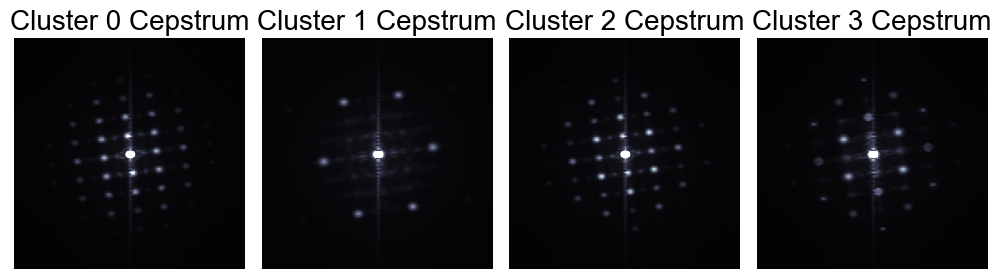

In [108]:
clim_ref = cep_nmf_avg_dict["nbed_2_avg_cep_nmf"]
c_max = clim_ref.mean() + 1*clim_ref.std()
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (12,3))
im1 = ax1.imshow(cep_nmf_avg_dict["nbed_0_avg_cep_nmf"], cmap = 'bone', vmin = 0, vmax = c_max)
ax1.axis('off')
ax1.set_title('Cluster 0 Cepstrum', fontsize = 20)
im2 = ax2.imshow(cep_nmf_avg_dict["nbed_1_avg_cep_nmf"], cmap = 'bone', vmin = 0, vmax = c_max)
ax2.axis('off')
ax2.set_title('Cluster 1 Cepstrum', fontsize = 20)
im3 = ax3.imshow(cep_nmf_avg_dict["nbed_2_avg_cep_nmf"], cmap = 'bone', vmin = 0, vmax = c_max)
ax3.axis('off')
ax3.set_title('Cluster 2 Cepstrum', fontsize = 20)
im4 = ax4.imshow(cep_nmf_avg_dict["nbed_3_avg_cep_nmf"], cmap = 'bone', vmin = 0, vmax = c_max)
ax4.axis('off')
ax4.set_title('Cluster 3 Cepstrum', fontsize = 20)
# im5 = ax5.imshow(cep_nmf_avg_dict["nbed_4_avg_cep_nmf"], cmap = 'bone', vmin = 0, vmax = c_max)
# ax5.axis('off')
# ax5.set_title('Cluster 4 Cepstrum', fontsize = 25)
# im6 = ax6.imshow(cep_nmf_avg_dict["nbed_5_avg_cep_nmf"], cmap = 'bone', vmin = 0, vmax = c_max)
# ax6.axis('off')
# ax6.set_title('Cluster 5 Cepstrum', fontsize = 25)

fig.subplots_adjust(right=.95, wspace = None, hspace = None)
#cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7]) # upper and lower limits, width, and length
#fig.colorbar(im1, cax=cbar_ax).ax.tick_params(labelsize = 25)
plt.subplots_adjust(wspace=0)
plt.show()

In [38]:
sma_cep_nmf_rec = (nmf2.inverse_transform(sma_cep_nmf)).reshape(sma_nmf.shape[0], IMG_SIZE, IMG_SIZE)
np.save('smaGacepnmfrec213-315', sma_cep_nmf_rec)

In [95]:
sma_cep_nmf_rec = np.load('smaGacepnmfrec213-315.npy')
sma_cep_nmf_rec.shape

(99225, 128, 128)

## Strain Mapping with Peak Pairs Method

<Figure size 800x800 with 0 Axes>

(-0.5, 127.5, 127.5, -0.5)

<Figure size 800x800 with 0 Axes>

(-0.5, 127.5, 127.5, -0.5)

<Figure size 800x800 with 0 Axes>

(-0.5, 127.5, 127.5, -0.5)

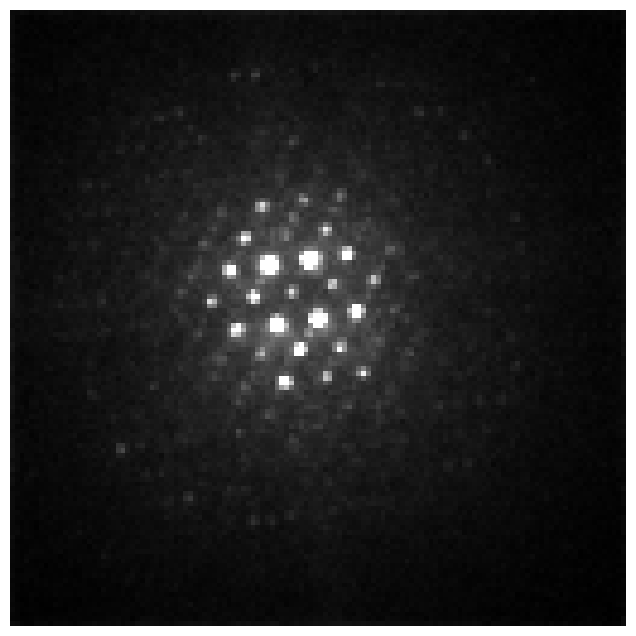

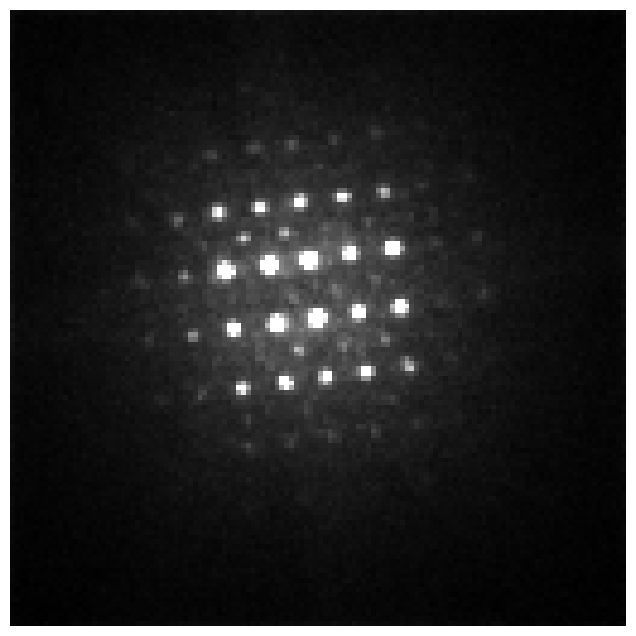

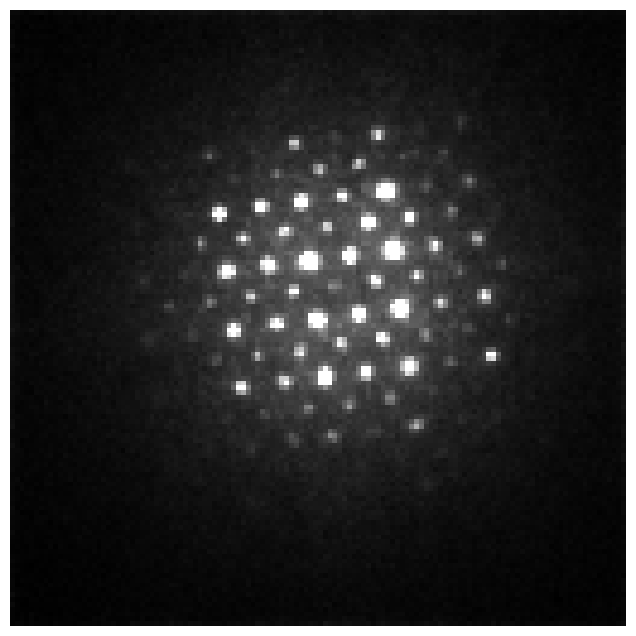

In [65]:
for i in (12000, 14000, 16000):
    Cep = sma_nbed[i]

    plt.figure(figsize=(8,8)) # why small? why rotated?
    plt.imshow(Cep, cmap = 'gray')
    #plt.colorbar(fraction = 0.03, pad = 0.02)
    plt.axis('off')
    plt.clim([0, Cep.mean() + 3*Cep.std()])

<Figure size 800x800 with 0 Axes>

(-0.5, 127.5, 127.5, -0.5)

<Figure size 800x800 with 0 Axes>

(-0.5, 127.5, 127.5, -0.5)

<Figure size 800x800 with 0 Axes>

(-0.5, 127.5, 127.5, -0.5)

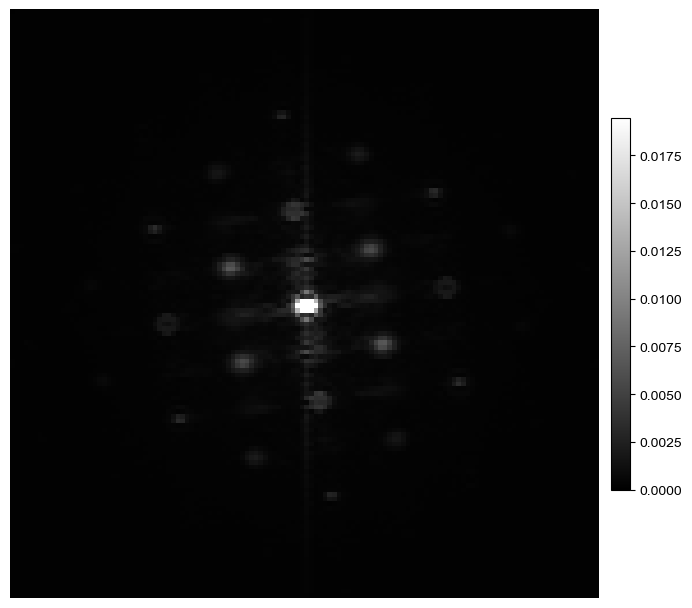

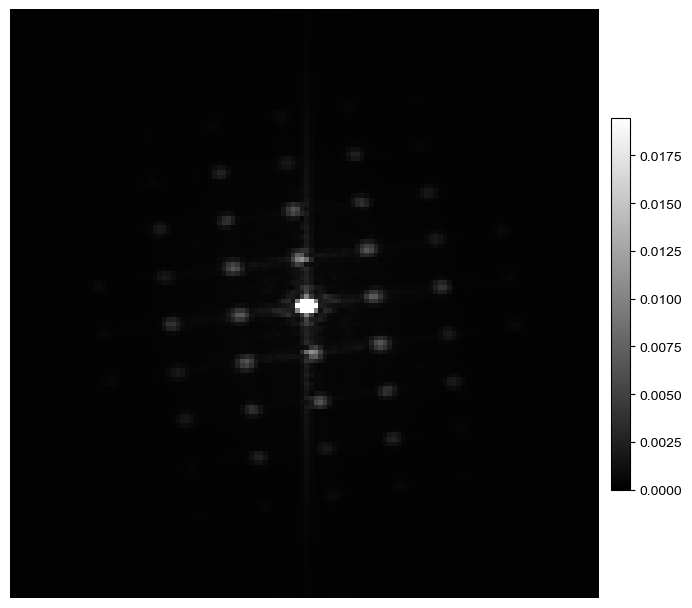

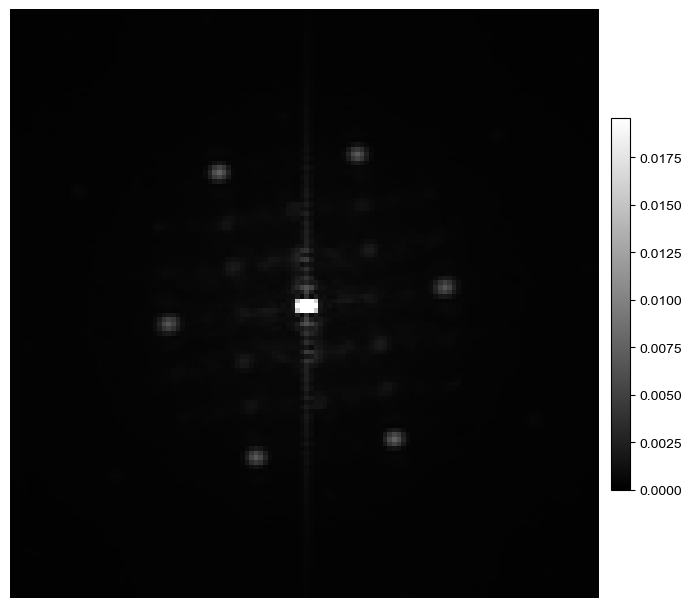

In [150]:
for i in (1000, 20000, 40000):
    Cep = sma_cep_nmf_rec[i] # Can use original or reconstructed cepstrum patterns, doesn't change results significantly. Figures in paper use original patterns

    plt.figure(figsize=(8,8)) # why small? why rotated?
    plt.imshow(Cep, cmap = 'gray')
    plt.colorbar(fraction = 0.03, pad = 0.02)
    plt.axis('off')
    plt.clim([0, Cep.mean() + 2*Cep.std()])


<Figure size 1200x1200 with 0 Axes>

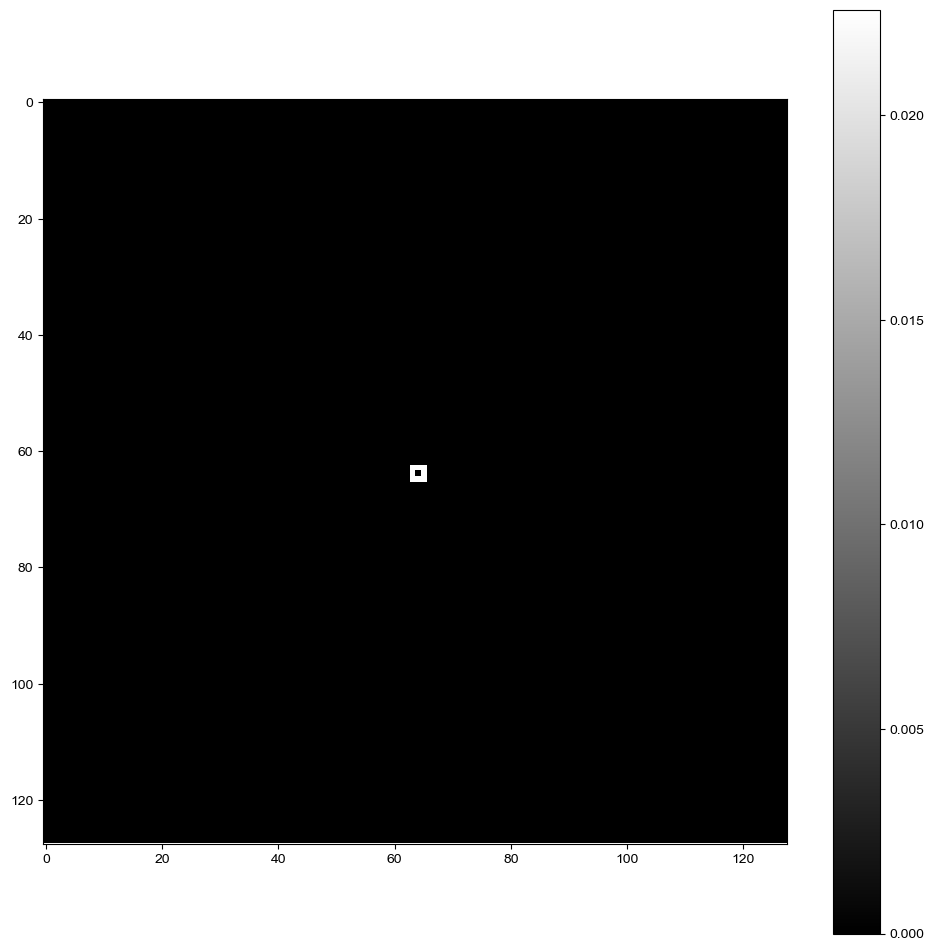

In [151]:
sob = canny(Cep, sigma = 1)#, low_threshold = 10, high_threshold = 20)
plt.figure(figsize = (12,12))
plt.imshow(sob, cmap = 'gray')
plt.colorbar()
plt.clim([0, sob.mean() + 1*sob.std()])

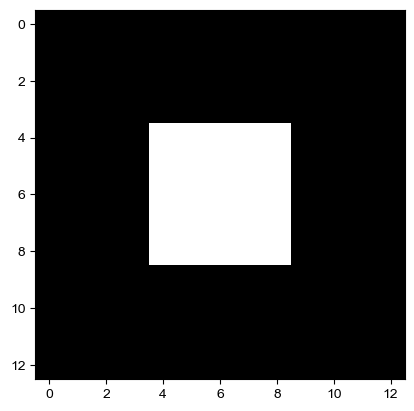

In [152]:
template = np.zeros((13,13))
r = 3
[aa,bb] = ellipse(6 ,6 , r, r)
template[aa,bb] = .005
plt.imshow(template, cmap = 'gray')

(20, 2)

<Figure size 1200x1200 with 0 Axes>

(-0.5, 127.5, 127.5, -0.5)

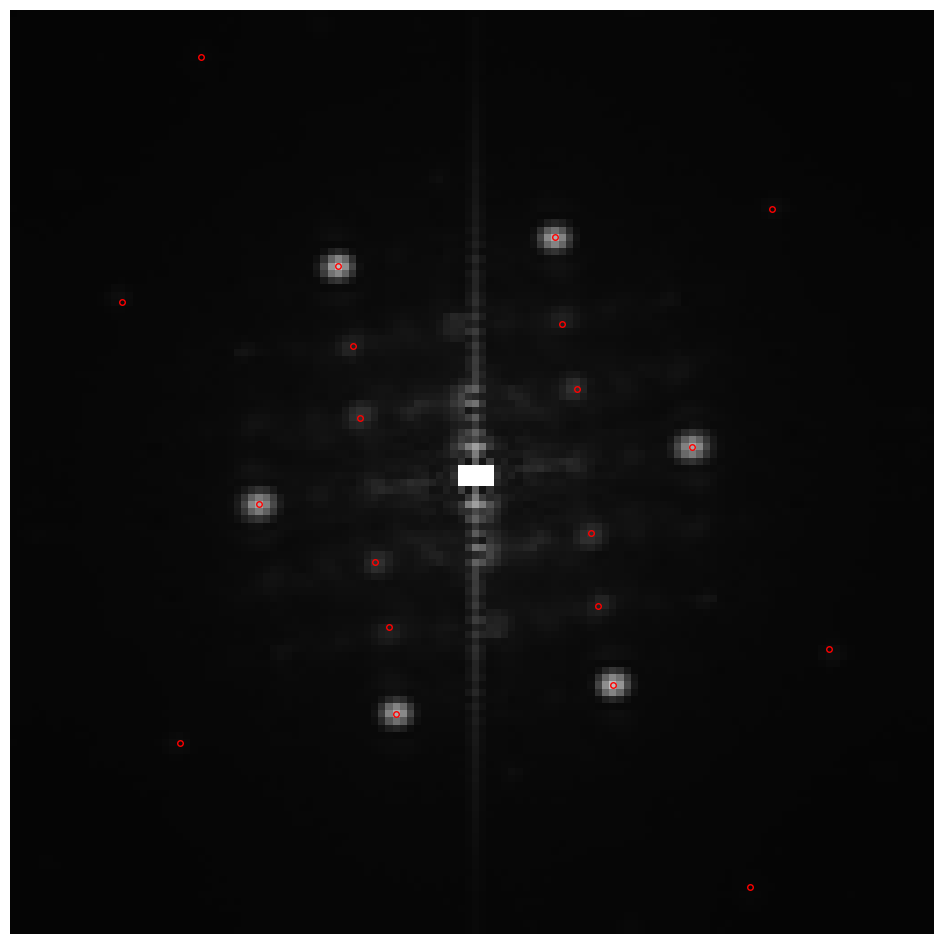

In [153]:
min_distance = 2*r
th = 0.7
match = match_template(Cep, template, pad_input = True)
peaks = peak_local_max(match,min_distance=min_distance,threshold_rel=th)
peaks.shape
plt.figure(figsize=(12,12))
plt.imshow(Cep, cmap = 'gray')
plt.clim([0, Cep.mean() + 1*Cep.std()])
plt.axis('off')
plt.plot(peaks[:,1], peaks[:,0], 'o', markeredgecolor='r', markerfacecolor='none', markersize=4)

<Figure size 1200x1200 with 0 Axes>

(-0.5, 127.5, 127.5, -0.5)

Text(91, 57, '0')

Text(31, 65, '1')

Text(50, 94, '2')

Text(72, 28, '3')

Text(42, 32, '4')

Text(80, 90, '5')

Text(77, 69, '6')

Text(45, 53, '7')

Text(23, 3, '8')

Text(49, 82, '9')

Text(73, 40, '10')

Text(75, 49, '11')

Text(47, 73, '12')

Text(44, 43, '13')

Text(78, 79, '14')

Text(12, 37, '15')

Text(110, 85, '16')

Text(99, 118, '17')

Text(102, 24, '18')

Text(20, 98, '19')

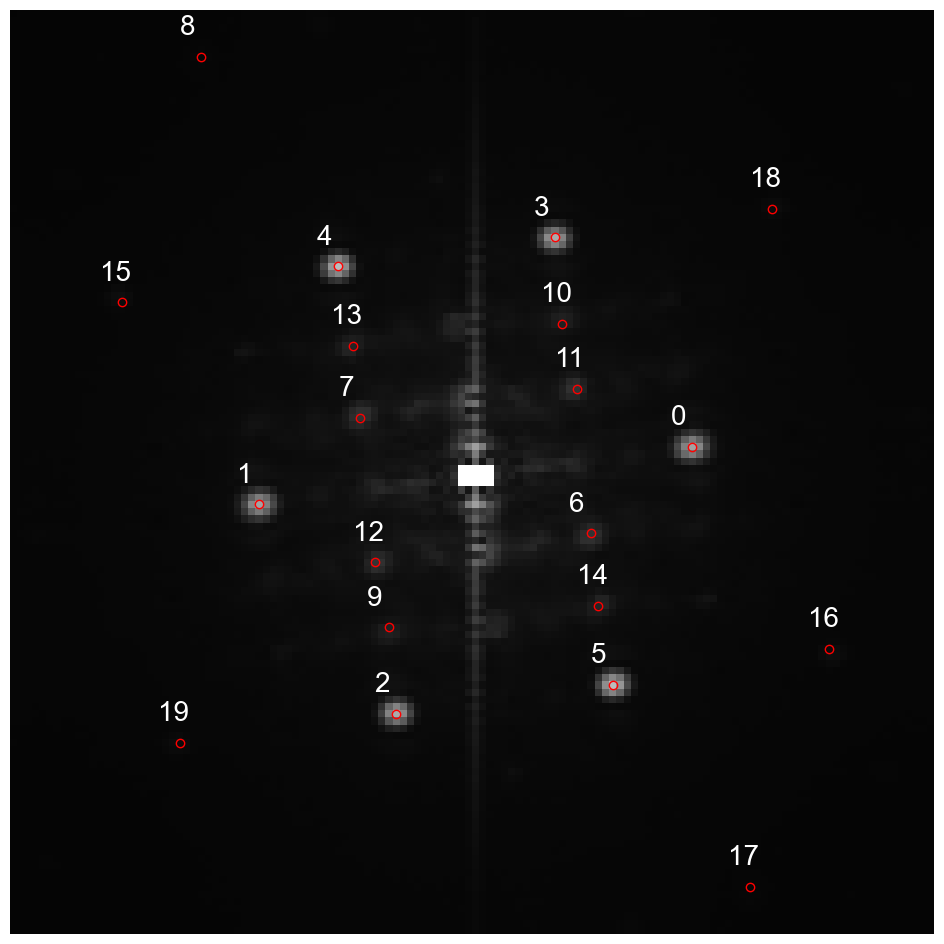

In [154]:
plt.figure(figsize=(12,12))
plt.imshow(Cep, cmap = 'gray')
plt.clim([0, Cep.mean() + 1*Cep.std()])
plt.plot(64, 64, 'y', markersize = 8)
plt.axis('off')
for i in range(len(peaks)):
    plt.plot(peaks[i,1], peaks[i,0], 'o', markeredgecolor='r', markerfacecolor='none', markersize=6)
    plt.annotate((str(i)), xy = (peaks[i,1] - 3, peaks[i,0] - 3), color = 'white', fontsize = 20)

In [155]:
def get_gauss(grid, region, initials):
    a, b = opt.curve_fit(GaussSingle, grid, region, p0 = initials)
    return a, b

In [156]:
def get_basis(dataset, peak_pairs, radius, rough_peaks):
    dataset = dataset # probably a nmf decomposed --> recovered array of cepstrums
    peak_pairs = peak_pairs # the list of 2 peaks from cross-correlation map
    rough_peaks = rough_peaks # list of peak positions (rough position estimates for Gaussian fiing)
    rr = radius # should be same as radius of ring template
    cent = dataset.shape[1]//2 # geing center coordinate of image to approximate center spot position
    au = []
    bv = []
    for i in range(len(dataset)):
        Ceps = dataset[i]
        w = h = 2*rr
        x = np.linspace(cent - 2*rr, cent + 2*rr , 2*(w)) 
        y = np.linspace(cent - 2*rr , cent + 2*rr , 2*(h))
        xydata0 = np.meshgrid(x, y)
        bg_guess0 = np.mean(lowest(Ceps[cent - 2*rr: cent + 2*rr, cent - 2*rr: cent + 2*rr].ravel(),8))
        amp_guess0 = np.mean(highest(Ceps[cent - 2*rr: cent + 2*rr, cent - 2*rr: cent + 2*rr].ravel(),8))
        xguess0 = cent
        yguess0 = cent
        init_guess0 = (amp_guess0, xguess0, yguess0, rr, rr, bg_guess0) 
        popt0, pcov0 = get_gauss(xydata0, Ceps[cent - 2*rr : cent + 2*rr , cent - 2*rr : cent + 2*rr ].ravel(), init_guess0)
        count = 0
        for pp in peak_pairs:
            x = np.linspace(rough_peaks[pp,1] - 2*rr , rough_peaks[pp,1] + 2*rr , 2*(w)) 
            y = np.linspace(rough_peaks[pp,0] - 2*rr , rough_peaks[pp,0] + 2*rr , 2*(h))
            xydata = np.meshgrid(x, y)
            bg_guess = np.mean(lowest(Ceps[rough_peaks[pp,0] - 2*rr: rough_peaks[pp,0] + 2*rr, rough_peaks[pp,1] - 2*rr: rough_peaks[pp,1] + 2*rr].ravel(),5))
            amp_guess = np.mean(highest(Ceps[rough_peaks[pp,0] - 2*rr: rough_peaks[pp,0] + 2*rr, rough_peaks[pp,1] - 2*rr: rough_peaks[pp,1] + 2*rr].ravel(),5))
            xguess = rough_peaks[pp,1]
            yguess = rough_peaks[pp,0]
            init_guess = (amp_guess, xguess, yguess, 2.5, 2.5, bg_guess)    
            try:
                popt, pcov = get_gauss(xydata, Ceps[rough_peaks[pp,0] - 2*rr : rough_peaks[pp,0] + 2*rr , rough_peaks[pp,1] - 2*rr : rough_peaks[pp,1] + 2*rr ].ravel(), init_guess)
            except:
                print(i,pp)
            vect = np.array([popt[1] - popt0[1], popt[2] - popt0[2]]) # vector 1 for first peak in x,y
            if count == 0:
                au.append(vect)
            elif count == 1:
                bv.append(vect)
            count += 1
    return np.asarray(au), np.asarray(bv)
        

In [93]:
unfit_u1, unfit_v1 = get_basis(sma_cep_nmf_rec, [3,0], 4, peaks)
unfit_u2, unfit_v2 = get_basis(sma_cep_nmf_rec, [2,1], 4, peaks)
#unfit_v3, unfit_v4 = get_basis(sma_cep_nmf_rec, [1,2], 3, peaks)

In [94]:
# i = 1962
# im = sma_cep_nmf_rec[i]
# plt.figure(figsize = (8,8))
# plt.imshow(im)
# plt.clim([0, im.mean() + im.std()])
# plt.plot(peaks[:,1], peaks[:,0], 'o', markeredgecolor='r', markerfacecolor='none', markersize=4)

# temp_p = [4,0,5,1]
# tt = 0
# rr = 4
# for pp in temp_p:
#     plt.figure()
#     plt.imshow(im[peaks[pp,0] - 2*rr+ tt: peaks[pp,0] + 2*rr+ tt, peaks[pp,1] - 2*rr+ tt: peaks[pp,1] + 2*rr+ tt])

In [ ]:
unfit_u = ((unfit_u1) - (unfit_u2))/2
unfit_u
unfit_v = ((unfit_v1) - (unfit_v2))/2
# unfit_v[:,0] = unfit_v[:,0] - unfit_v3[:,0] + unfit_v4[:,0]
# unfit_v[:,1] = unfit_v[:,1] + unfit_v3[:,1] - unfit_v4[:,1]
# unfit_v = unfit_v/4
unfit_v

In [121]:
np.save("unfit_u_213-315", unfit_u)
np.save("unfit_v_213-315", unfit_v)

In [109]:
unfit_u = np.load("unfit_u_213-315.npy")
unfit_v = np.load("unfit_v_213-315.npy")

In [110]:
unfit_u.shape
unfit_v.shape

(99225, 2)

(99225, 2)

In [111]:
kernel = np.ones((11,11))

In [112]:
kernel

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

(-0.5, 314.5, 314.5, -0.5)

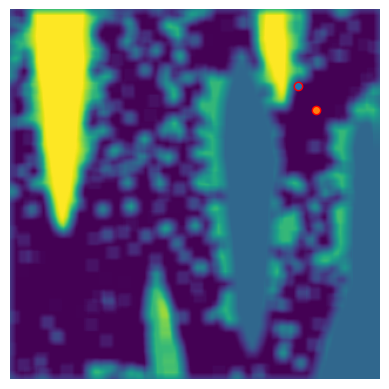

In [113]:
find_mat = signal.convolve2d(cluster_map_cep_nmf, kernel, mode = 'same', fillvalue = 1)
plt.imshow(np.abs(find_mat))
plt.axis('off')
plt.plot(245, 65, 'o', markeredgecolor='r')
plt.plot(260, 85, 'o', markeredgecolor='r')
#plt.colorbar()

In [114]:
find_mat.shape

(315, 315)

In [115]:
matrix_pts = np.asarray(np.where(np.abs(find_mat == 0))).T
matrix_pts.shape
#ss = np.random.permutation(matrix_pts.shape[0])

(16994, 2)

# As larger FOV is more heterogeneous, points of cluster 0 only from a particular region of the scan were used as reference. Using all would have produced similar results, but this way seemed more sensible

In [116]:
ind_bot_left = np.asarray(np.where((matrix_pts[:,0] < 85) & (matrix_pts[:,0] > 65) & (matrix_pts[:,1] > 245) * (matrix_pts[:,1] < 260)))
ind_bot_left

array([[2340, 2341, 2342, 2343, 2344, 2345, 2346, 2347, 2348, 2349, 2350,
        2351, 2352, 2353, 2397, 2398, 2399, 2400, 2401, 2402, 2403, 2404,
        2405, 2406, 2407, 2408, 2409, 2410, 2458, 2459, 2460, 2461, 2462,
        2463, 2464, 2465, 2466, 2467, 2468, 2469, 2470, 2471, 2519, 2520,
        2521, 2522, 2523, 2524, 2525, 2526, 2527, 2528, 2529, 2530, 2531,
        2532, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590,
        2591, 2592, 2593, 2594, 2651, 2652, 2653, 2654, 2655, 2656, 2657,
        2658, 2659, 2660, 2661, 2662, 2663, 2664, 2713, 2714, 2715, 2716,
        2717, 2718, 2719, 2720, 2721, 2722, 2723, 2724, 2725, 2726, 2773,
        2774, 2775, 2776, 2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784,
        2785, 2786, 2825, 2826, 2827, 2828, 2829, 2830, 2831, 2832, 2833,
        2834, 2835, 2836, 2837, 2838, 2875, 2876, 2877, 2878, 2879, 2880,
        2881, 2882, 2883, 2884, 2885, 2886, 2887, 2888, 2925, 2926, 2927,
        2928, 2929, 2930, 2931, 2932, 

In [117]:
matrix_pts[ind_bot_left]

array([[[ 66, 246],
        [ 66, 247],
        [ 66, 248],
        [ 66, 249],
        [ 66, 250],
        [ 66, 251],
        [ 66, 252],
        [ 66, 253],
        [ 66, 254],
        [ 66, 255],
        [ 66, 256],
        [ 66, 257],
        [ 66, 258],
        [ 66, 259],
        [ 67, 246],
        [ 67, 247],
        [ 67, 248],
        [ 67, 249],
        [ 67, 250],
        [ 67, 251],
        [ 67, 252],
        [ 67, 253],
        [ 67, 254],
        [ 67, 255],
        [ 67, 256],
        [ 67, 257],
        [ 67, 258],
        [ 67, 259],
        [ 68, 246],
        [ 68, 247],
        [ 68, 248],
        [ 68, 249],
        [ 68, 250],
        [ 68, 251],
        [ 68, 252],
        [ 68, 253],
        [ 68, 254],
        [ 68, 255],
        [ 68, 256],
        [ 68, 257],
        [ 68, 258],
        [ 68, 259],
        [ 69, 246],
        [ 69, 247],
        [ 69, 248],
        [ 69, 249],
        [ 69, 250],
        [ 69, 251],
        [ 69, 252],
        [ 69, 253],


In [118]:
mat_pts_flat = np.asarray(np.where(np.abs(find_mat.ravel() == 0))).T

In [119]:
mat_pts_4_ref = (mat_pts_flat[ind_bot_left])[0]
mat_pts_4_ref.shape
fullprint(mat_pts_4_ref)

(266, 1)

array([[21036],
       [21037],
       [21038],
       [21039],
       [21040],
       [21041],
       [21042],
       [21043],
       [21044],
       [21045],
       [21046],
       [21047],
       [21048],
       [21049],
       [21351],
       [21352],
       [21353],
       [21354],
       [21355],
       [21356],
       [21357],
       [21358],
       [21359],
       [21360],
       [21361],
       [21362],
       [21363],
       [21364],
       [21666],
       [21667],
       [21668],
       [21669],
       [21670],
       [21671],
       [21672],
       [21673],
       [21674],
       [21675],
       [21676],
       [21677],
       [21678],
       [21679],
       [21981],
       [21982],
       [21983],
       [21984],
       [21985],
       [21986],
       [21987],
       [21988],
       [21989],
       [21990],
       [21991],
       [21992],
       [21993],
       [21994],
       [22296],
       [22297],
       [22298],
       [22299],
       [22300],
       [22301],
       [

In [120]:
basis_ax = unfit_u[mat_pts_4_ref][:,0][:,0].mean()
basis_ay = unfit_u[mat_pts_4_ref][:,0][:,1].mean()
basis_bx = unfit_v[mat_pts_4_ref][:,0][:,0].mean()
basis_by = unfit_v[mat_pts_4_ref][:,0][:,1].mean()
basis_ax
basis_ay
basis_bx
basis_by

21.294675783240482

-65.81336182595979

29.35668717590833

-4.048931423523435

In [121]:
real_u = unfit_u - [basis_ax, basis_ay]
real_v = unfit_v - [basis_bx, basis_by]

In [122]:
uvx = np.vstack((real_u[:,0], real_v[:,0]))

uvy = np.vstack((real_u[:,1], real_v[:,1]))

In [123]:
uvx.shape

(2, 99225)

In [124]:
mat_A = np.array([[basis_ax, basis_ay],[basis_bx, basis_by]])
mat_A.shape
mat_A

(2, 2)

array([[ 21.29467578, -65.81336183],
       [ 29.35668718,  -4.04893142]])

In [125]:
Ey = np.matmul(np.linalg.inv(mat_A), uvy)
Ex = np.matmul(np.linalg.inv(mat_A), uvx)
Ey.shape
Ex.shape

(2, 99225)

(2, 99225)

In [126]:
eps_xx = Ex[0].reshape(ScanX, ScanY) # based on equation in peak pairs paper
eps_yy = Ey[1].reshape(ScanX, ScanY)
eps_xy = Ex[1].reshape(ScanX, ScanY)
eps_yx = Ey[0].reshape(ScanX, ScanY)

In [127]:
min1 = np.abs(np.array([Ey, Ex]).min())
max1 = np.array([Ey, Ex]).max()
min1, max1
clim = np.mean((min1,max1)) + np.std((min1,max1))

(0.016506524941220103, 0.04109622068533669)

In [128]:
global_min = -1*clim
global_max = clim

(-0.5, 314.5, 314.5, -0.5)

(-0.5, 314.5, 314.5, -0.5)

(-0.5, 314.5, 314.5, -0.5)

(-0.5, 314.5, 314.5, -0.5)

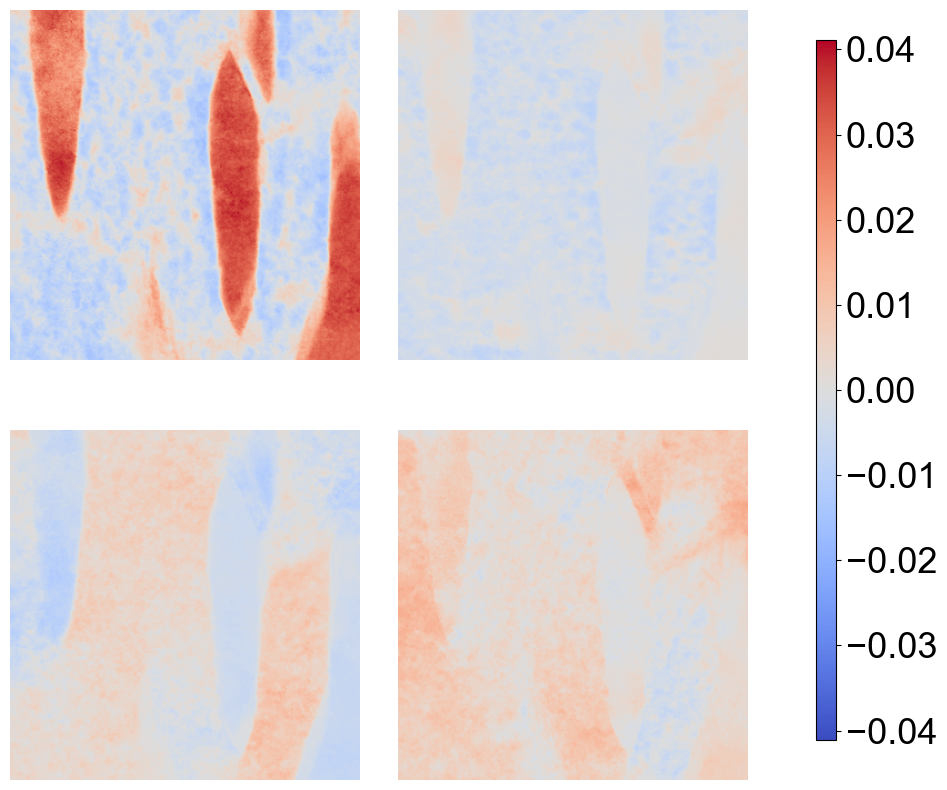

In [129]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (10,10))
im1 = ax1.imshow(eps_xx, cmap = 'coolwarm', vmin = global_min, vmax = global_max)
ax1.axis('off')
#ax1.set_title('$\epsilon_{xx}$', fontsize = 30)
im2 = ax2.imshow(eps_yy, cmap = 'coolwarm', vmin = global_min, vmax = global_max)
ax2.axis('off')
#ax2.set_title('$\epsilon_{yy}$', fontsize = 30)
im3 = ax3.imshow(eps_xy, cmap = 'coolwarm', vmin = global_min, vmax = global_max)
ax3.axis('off')
#ax3.set_title('$\epsilon_{xy}$', fontsize = 30)
im4 = ax4.imshow(eps_yx, cmap = 'coolwarm', vmin = global_min, vmax = global_max)
ax4.axis('off')
#ax4.set_title('$\epsilon_{yx}$', fontsize = 30)

fig.subplots_adjust(right=.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7]) # white space, length, width, vertical height (?)
fig.colorbar(im1, cax=cbar_ax).ax.tick_params(labelsize = 26)
plt.subplots_adjust(wspace=0)
plt.show()

plt.show()

(-0.5, 314.5, 314.5, -0.5)

(-0.5, 314.5, 314.5, -0.5)

(-0.5, 314.5, 314.5, -0.5)

(-0.5, 314.5, 314.5, -0.5)

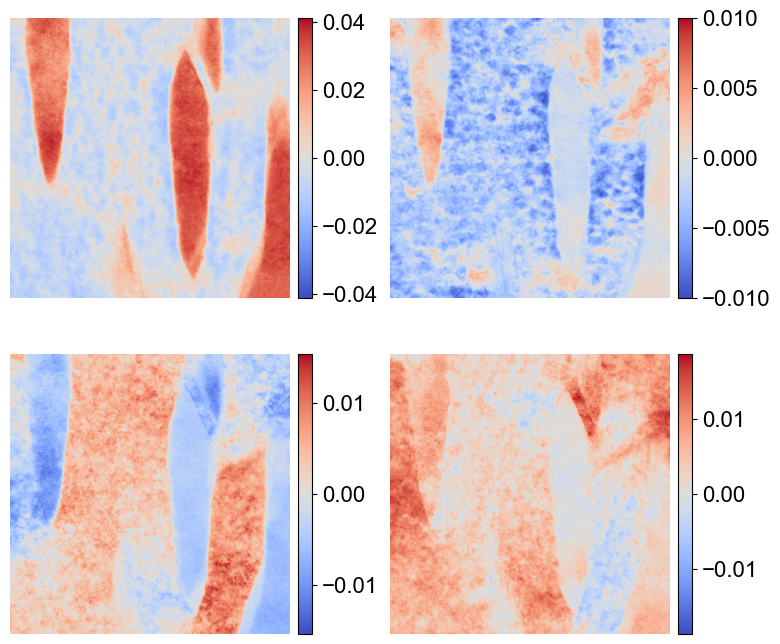

In [140]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2 , figsize = (9,8))
im1 = ax1.imshow(eps_xx, cmap = 'coolwarm', vmin = -1*np.max(np.abs(eps_xx)), vmax = np.max(np.abs(eps_xx)))
ax1.axis('off')
#ax1.set_title('$\epsilon_{xx}$', fontsize = 26)
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.08)
fig.colorbar(im1, cax=cax, orientation='vertical').ax.tick_params(labelsize = 16)
im2 = ax2.imshow(eps_yy, cmap = 'coolwarm', vmin = np.round(-1*np.max(np.abs(eps_yy)),2), vmax = np.round(np.max(np.abs(eps_yy)),2))
ax2.axis('off')
#ax2.set_title('$\epsilon_{yy}$', fontsize = 26)
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.08)
fig.colorbar(im2, cax=cax, orientation='vertical').ax.tick_params(labelsize = 16)
im3 = ax3.imshow(eps_xy, cmap = 'coolwarm', vmin = -1*np.max(np.abs(eps_xy)), vmax = np.max(np.abs(eps_xy)))
ax3.axis('off')
#ax3.set_title('$\epsilon_{xy}$', fontsize = 26)
divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.08)
fig.colorbar(im3, cax=cax, orientation='vertical').ax.tick_params(labelsize = 16)
im4 = ax4.imshow(eps_yx, cmap = 'coolwarm', vmin = -1*np.max(np.abs(eps_yx)), vmax = np.max(np.abs(eps_yx)))
ax4.axis('off')
#ax4.set_title('$\epsilon_{yx}$', fontsize = 26)
divider = make_axes_locatable(ax4)
cax = divider.append_axes('right', size='5%', pad=0.08)
fig.colorbar(im4, cax=cax, orientation='vertical').ax.tick_params(labelsize = 16)

# fig.subplots_adjust(right=.85)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.015, 0.7]) # upper and lower limits, width, and length
# fig.colorbar(im1, cax=cbar_ax).ax.tick_params(labelsize = 20)
# plt.subplots_adjust(wspace=0)
# plt.show()

plt.show()